In [1]:
%matplotlib widget

import numpy as np
import random
import pandas as pd
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, make_scorer, mean_squared_error, silhouette_samples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.lines import Line2D
import yaml
from IPython.display import display  # to display variables in a "nice" way

try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

pd.options.display.max_rows = 140
pd.options.display.max_columns = 200

In [2]:
rs = 296312+302736
df_path = "responses_hw.csv" 
df = pd.read_csv(df_path)

# 1 Loading and Preparing the Data

In [3]:
df_demographics = df.iloc[:, -10:]
df = df.iloc[:,:-10]

In [4]:
col_entertainment = list(df.columns)[0:63]
col_personality = list(df.columns)[63:140]
np.random.seed(rs)
remove_entertainment = np.random.choice(col_entertainment,5)
remove_personality = np.random.choice(col_personality,10)
print(remove_entertainment)
print(remove_personality)

['Country' 'Geography' 'Latino' 'Slow songs or fast songs' 'Chemistry']
['Personality' 'Loneliness' 'Reliability' 'New environment' 'Fake'
 'Heights' 'Internet usage' 'Prioritising workload' 'Interests or hobbies'
 'Mood swings']


# 2 Preprocessing

In [5]:
data = {'Smoking': {'never smoked': 1, 'tried smoking':2, 'former smoker':3, 'current smoker':4},
        'Alcohol': {'never':1, 'social drinker': 2, 'drink a lot':3},
        'Punctuality': {'early':1, 'on time':2, 'late':3},
        'Lying': {'never':1, 'only to avoid hurting someone': 2, 'sometimes':3 ,'everytime it suits me':4},
        'Internet usage': {'no time at all':1, 'less than an hour a day':2, 'few hours a day':3, 'most of the day':4}      
       }
df = df.replace(data)
df_1 = df.iloc[:,0:63]
df_2 = df.iloc[:, 63:]

In [6]:
workdf_1 = df_1.drop(columns=remove_entertainment)
workdf_2 = df_2.drop(columns=remove_personality)
workdf_tot = pd.concat((workdf_1, workdf_2), axis = 1)

In [7]:
workdf_tot_na = workdf_tot.dropna()
workdf_1_na = workdf_1.dropna()
X_tot_na = workdf_tot_na.values
X_1_na = workdf_1_na.values
print(workdf_tot_na.values.shape)
print(workdf_1_na.values.shape)

(726, 125)
(831, 58)


In [8]:
workdf_tot_0 = workdf_tot.fillna(value = 0)
workdf_1_0 = workdf_1.fillna(value = 0)
X_tot_0 = workdf_tot_0.values
X_1_0 = workdf_1_0.values

In [9]:
workdf_1_med = workdf_1.fillna(value = workdf_1.median(axis=0))
workdf_tot_med = workdf_tot.fillna(value = workdf_tot.median(axis=0))
X_tot_med = workdf_tot_med.values
X_1_med = workdf_1_med.values

# 3 Computation of the PCs

In [10]:
dict_df1 = {"Data with deleted rows" : X_1_na , "Data with 0 instead of NaN": X_1_0, "Data with median instead of NaN": X_1_med}

In [11]:
# aggiungere roba al print
dict_pca_1 = {}
dict_y_1 = {}
for k, v in dict_df1.items():
    pca = PCA(n_components = 0.3)
    pca.fit(v)
    m = min(pca.n_components_, 5)
    print('Il minimo è', m)
    dict_pca_1[k] = (PCA(n_components = m))
    dict_pca_1[k].fit(v)
    dict_y_1[k] = dict_pca_1[k].transform(v)
    
    
dict_pca_1

Il minimo è 4
Il minimo è 4
Il minimo è 4


{'Data with deleted rows': PCA(n_components=4),
 'Data with 0 instead of NaN': PCA(n_components=4),
 'Data with median instead of NaN': PCA(n_components=4)}

Scelta della migliore PCA

In [12]:
for k,v in dict_pca_1.items():
    recon = v.inverse_transform(dict_y_1[k])
    print("score di sklearn {} ".format(v.score(dict_df1[k])))
    rmse = mean_squared_error(dict_df1[k], recon,squared=False)
    print("RMSE: {} ".format(rmse))

score di sklearn -90.35279704771877 
RMSE: 1.0337759010655552 
score di sklearn -91.35677228705954 
RMSE: 1.054728094466791 
score di sklearn -90.40681317076266 
RMSE: 1.0352708627859404 


In [13]:
pca_1 = dict_pca_1["Data with deleted rows"]
X_1 = dict_df1["Data with deleted rows"]
Y_1 = dict_y_1["Data with deleted rows"]

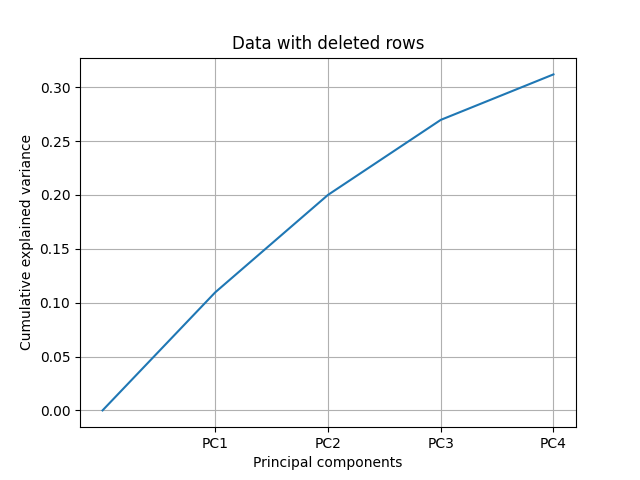

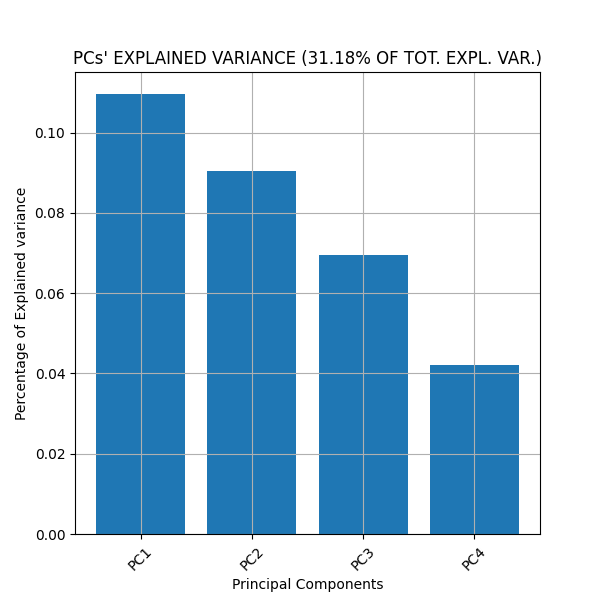

In [14]:
    m = pca_1.n_components
    # Curve of cumulative percentage of explained variance
    plt.figure()
    plt.plot(np.insert(np.cumsum(pca_1.explained_variance_ratio_), 0, 0))
    plt.title("Data with deleted rows")
    plt.xticks(ticks=np.arange(1, m + 1), 
               labels=[f'PC{i}' for i in range(1, m + 1)])
    plt.xlabel('Principal components')
    plt.ylabel('Cumulative explained variance')
    plt.grid()
    plt.show()
    
    round_expl_var_ratio = np.round(pca_1.explained_variance_ratio_.sum() * 100, decimals=2)

    # Barplot of percentage of explained variance
    plt.figure(figsize=(6, 6))
    plt.bar(range(1, m + 1), pca_1.explained_variance_ratio_)
    plt.title(f"PCs' EXPLAINED VARIANCE ({round_expl_var_ratio}% OF TOT. EXPL. VAR.)")
    plt.xticks(ticks=np.arange(1, m + 1), 
               labels=[f'PC{i}' for i in range(1, m + 1)],
               rotation=45)
    plt.xlabel('Principal Components')
    plt.ylabel('Percentage of Explained variance')
    plt.grid()
    plt.show()

# 4 Interpretation of the PCs

In [15]:
cat_colors={} 
 
# Colors initialization for Music Preferences 
for el in list(workdf_1.columns)[:16]: 
    cat_colors[el]= 'tab:blue' 
     
# Colors initialization for Movie Preferences 
for el in list(workdf_1.columns)[16:28]: 
    cat_colors[el]= 'tab:orange' 

# Colors initialization for Hobbies Interests 
for el in list(workdf_1.columns)[28:]: 
    cat_colors[el]= 'tab:green'
     
list_colors = [] 
for k,v in cat_colors.items(): 
    list_colors.append(cat_colors[k])

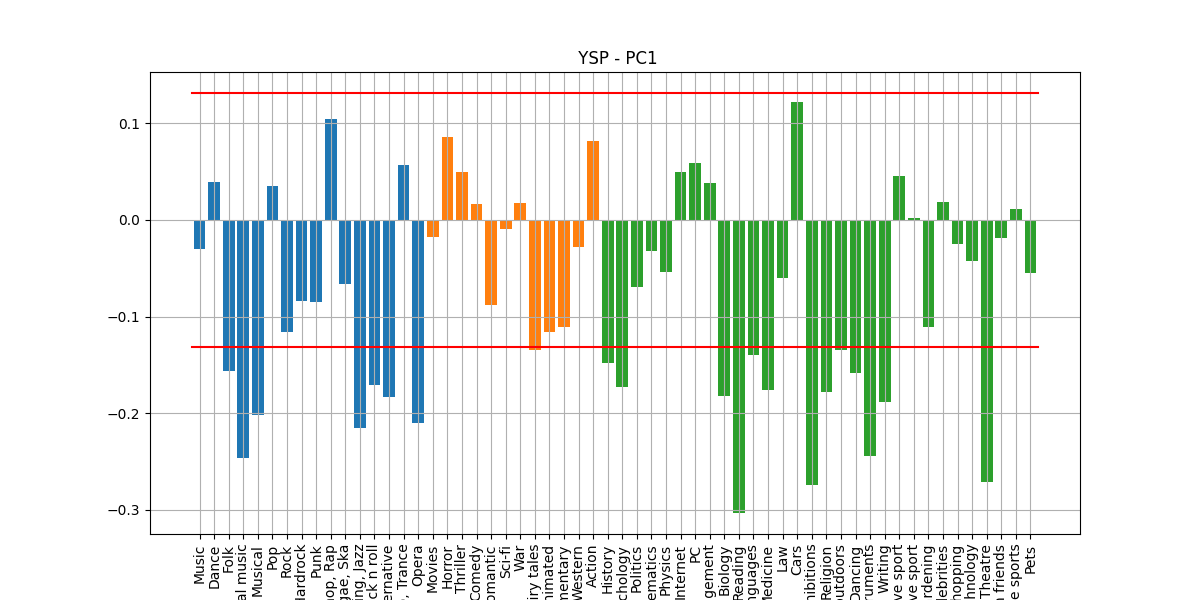


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: []

HIGH-VALUED NEGATIVE COMPONENTS: ['Folk', 'Classical music', 'Musical', 'Swing, Jazz', 'Rock n roll', 'Alternative', 'Opera', 'Fantasy/Fairy tales', 'History', 'Psychology', 'Biology', 'Reading', 'Foreign languages', 'Medicine', 'Art exhibitions', 'Religion', 'Countryside, outdoors', 'Dancing', 'Musical instruments', 'Writing', 'Theatre']
*********************************************



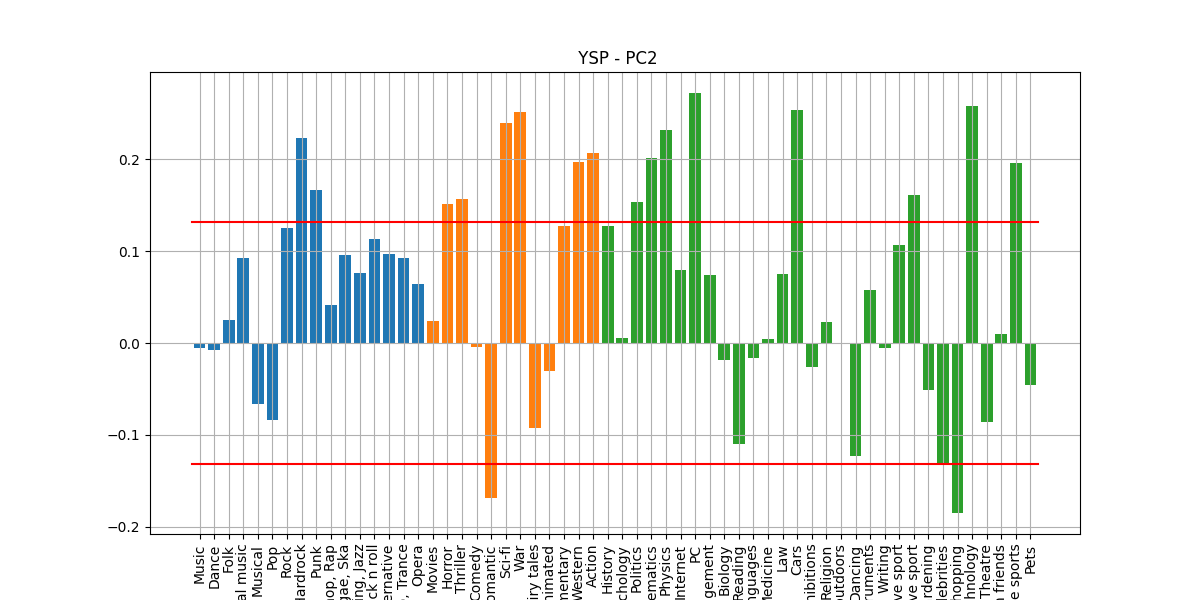


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Metal or Hardrock', 'Punk', 'Horror', 'Thriller', 'Sci-fi', 'War', 'Western', 'Action', 'Politics', 'Mathematics', 'Physics', 'PC', 'Cars', 'Active sport', 'Science and technology', 'Adrenaline sports']

HIGH-VALUED NEGATIVE COMPONENTS: ['Romantic', 'Shopping']
*********************************************



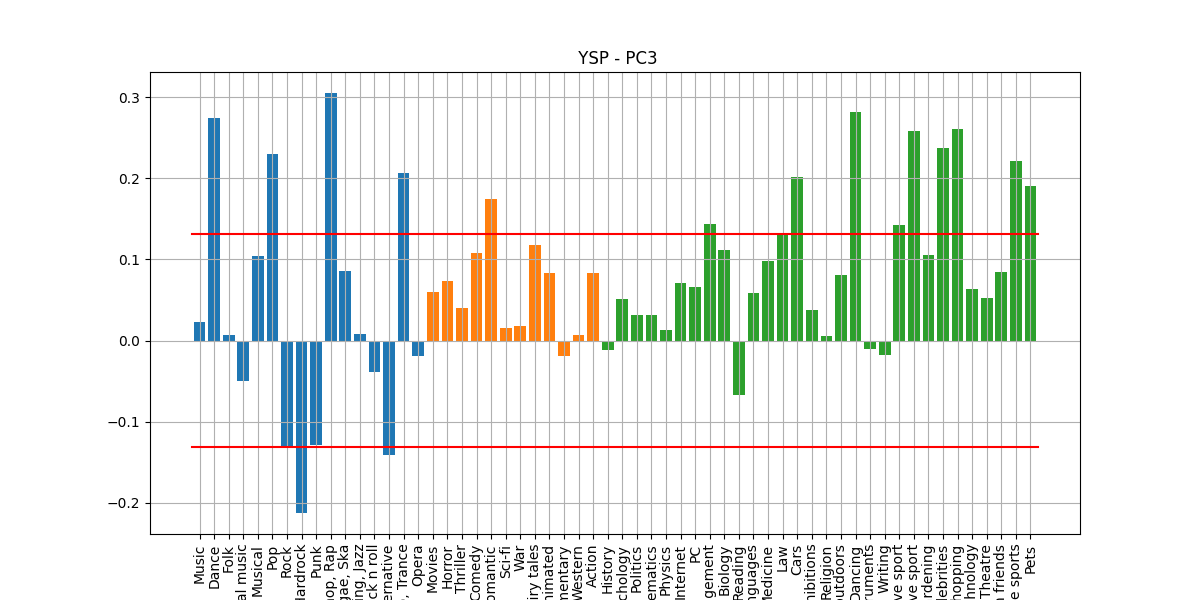


****************** PC3 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Dance', 'Pop', 'Hiphop, Rap', 'Techno, Trance', 'Romantic', 'Economy Management', 'Law', 'Cars', 'Dancing', 'Passive sport', 'Active sport', 'Celebrities', 'Shopping', 'Adrenaline sports', 'Pets']

HIGH-VALUED NEGATIVE COMPONENTS: ['Metal or Hardrock', 'Alternative']
*********************************************



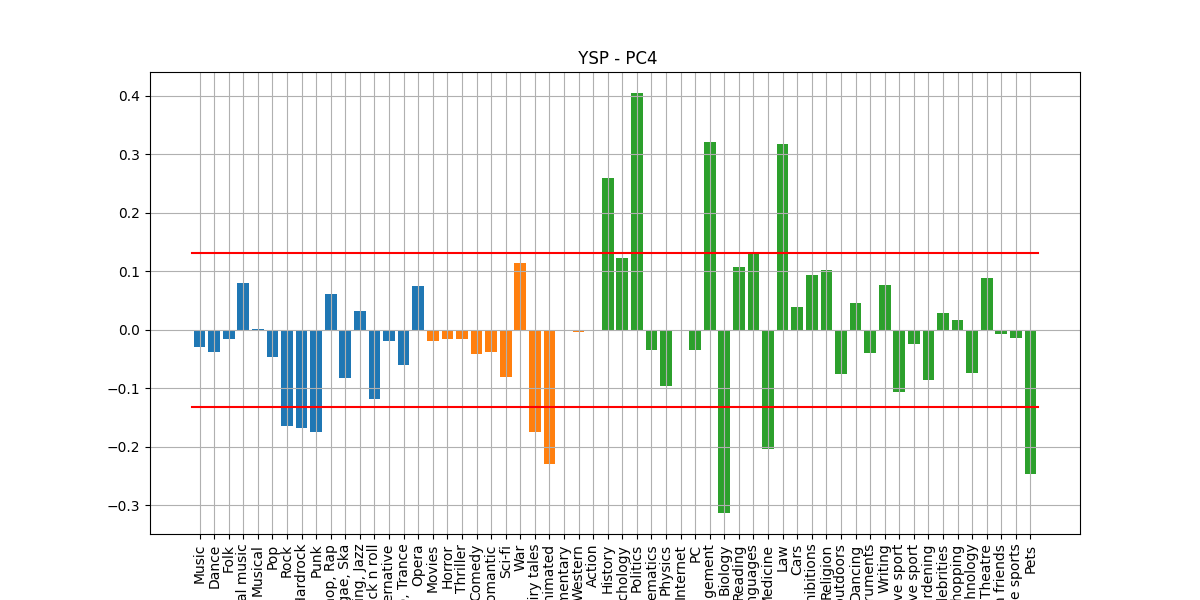


****************** PC4 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['History', 'Politics', 'Economy Management', 'Foreign languages', 'Law']

HIGH-VALUED NEGATIVE COMPONENTS: ['Rock', 'Metal or Hardrock', 'Punk', 'Fantasy/Fairy tales', 'Animated', 'Biology', 'Medicine', 'Pets']
*********************************************



In [16]:
for i in range(pca_1.n_components_):
    # DEFINE EPSILON
    eps = np.sqrt(1 / pca_1.n_features_)

    plt.figure(figsize = (12, 6))
    
    # --- RED LINE DENOTING THE THRESHOLD [-eps, +eps] ----------------
    plt.plot([-0.5, pca_1.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_1.n_features_ - 0.5], [-eps, -eps], 'red')
    
    plt.bar(np.arange(pca_1.n_features_), pca_1.components_[i, :], color = list_colors)  
    plt.xticks(ticks = np.arange(pca_1.n_features_), 
                   labels = workdf_1_na.columns.to_list(),
                   rotation = 90)
    plt.title(f' YSP - PC{i+1}')
    plt.grid()
    plt.show()
    # THE SELECTION OF THE SKILLS WITH CONTRIBUTE GREATER THAN THE THRESHOLD
    ind_great_pos_PCii = np.argwhere(pca_1.components_[i, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_1.components_[i, :] <= -eps).flatten()
    
    great_pos_PCii = [list(workdf_1_na.columns)[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [list(workdf_1_na.columns)[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{i+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')


In [17]:
pc_names_1 = ['Artists', 'Geeks', 'Influencers', 'Preppy']

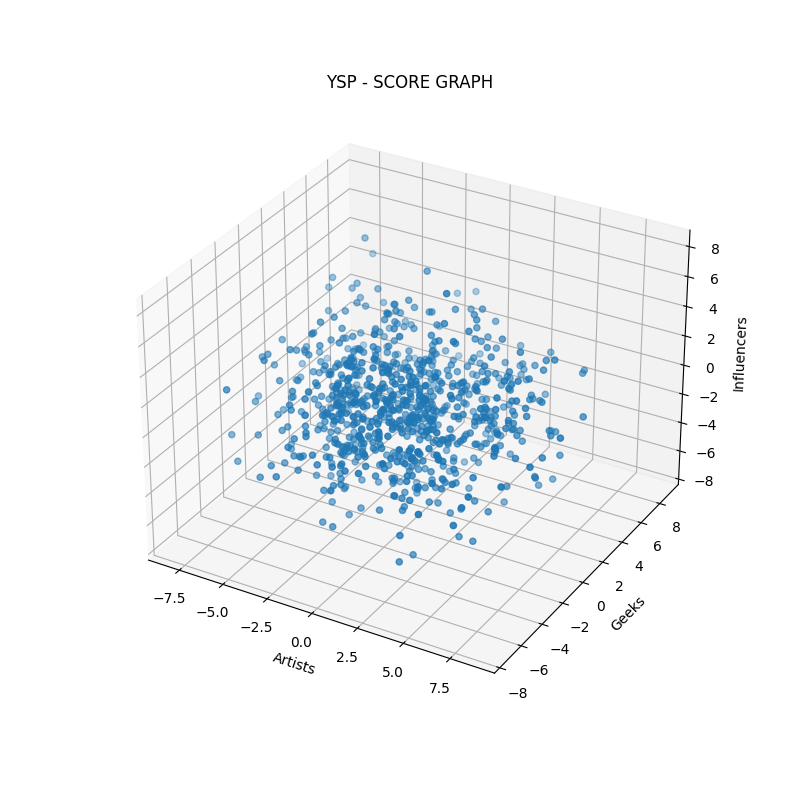

In [18]:
#Score Graph
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y_1[:, 0], Y_1[:, 1], Y_1[:, 2])
plt.title('YSP - SCORE GRAPH')
ax.set_xlabel(pc_names_1[0])
ax.set_ylabel(pc_names_1[1])
ax.set_zlabel(pc_names_1[2])
plt.grid()
plt.show()

# 5 k-Means

In [19]:
# List of values of the hyperparameters 
nclust_list = list(range(3, 11)) 
n_init_list = [3,10] 
iter_list = [300, 500, 1000] 
 
# Dictionarary for the GridSearch  
hparameters = {'n_clusters':nclust_list, 'n_init':n_init_list, 'max_iter':iter_list} 
km = KMeans(random_state=rs) 
 
# Defining the silohutte_scorer fot the GS 
def silhouette_scorer(estimator, X): 
    estimator.fit(X) 
    cluster_labels = estimator.labels_ 
    num_labels = len(set(cluster_labels)) 
    num_samples = X.shape[0] 
    if num_labels == 1 or num_labels == num_samples: 
        return -1 
    else: 
        return silhouette_score(X, cluster_labels) 
     
# Setting to none the slice of the cross validation for not using it 
cv = [(slice(None), slice(None))] 
 
km_gs = GridSearchCV(estimator=km, param_grid=hparameters,  
                  scoring=silhouette_scorer, cv=cv, n_jobs=-1) 
km_gs.fit(Y_1)

# Results of the GridSearch 
display(pd.DataFrame(km_gs.best_params_, index = ['Best Parameters'])) 
print(f'The best silhoutte score is {km_gs.best_score_}')  
df_results = pd.DataFrame(km_gs.cv_results_) 
display(df_results.sort_values(['rank_test_score'], ascending=True).head())

max_iter  n_clusters  n_init
Best Parameters       300           3       3

The best silhoutte score is 0.21160769531553064


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.023404           0.0         0.042208             0.0   
17       0.071677           0.0         0.091267             0.0   
32       0.020636           0.0         0.042393             0.0   
16       0.024760           0.0         0.042214             0.0   
33       0.064654           0.0         0.096555             0.0   

   param_max_iter param_n_clusters param_n_init  \
0             300                3            3   
17            500                3           10   
32           1000                3            3   
16            500                3            3   
33           1000                3           10   

                                               params  split0_test_score  \
0     {'max_iter': 300, 'n_clusters': 3, 'n_init': 3}           0.211608   
17   {'max_iter': 500, 'n_clusters': 3, 'n_init': 10}           0.211608   
32   {'max_iter': 1000, 'n_clusters': 3, 'n_init': 3}           0.211608   
16    {'max_iter': 500, 'n_clusters': 3, 'n_init': 3}           0.211608   
33  {'max_iter': 1000, 'n_clusters': 3, 'n_init': 10}           0.211608   

    mean_test_score  std_test_score  rank_test_score  
0          0.211608             0.0                1  
17         0.211608             0.0                1  
32         0.211608             0.0                1  
16         0.211608             0.0                1  
33         0.211608             0.0                1

In [20]:
km = KMeans(random_state= rs, max_iter= 300, n_clusters= 3, n_init= 3) 
km.fit(Y_1) 
silhouette_score(Y_1, km.labels_)

0.21160769531553064

# 6 Centroid Interpretation and Visualization

In [21]:
n_clusters = km.n_clusters
cluster_colors = []
markers_dict = {0: 'o', 1: '^', 2: 'x'}
col_dict = {0:'blue', 1:'orange', 2:'green'}
# Colors initialization for Music Preferences 
for el in km.labels_: 
    if el == 0:
        cluster_colors.append('tab:blue')
    if el == 1:
        cluster_colors.append('tab:orange')
    if el == 2:
        cluster_colors.append('tab:green')

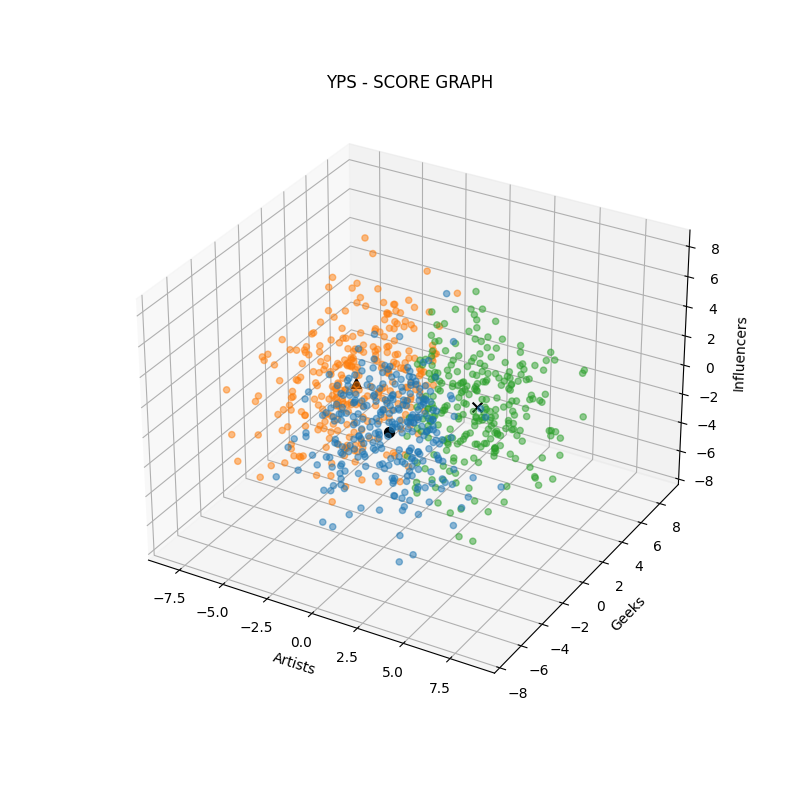

In [22]:
# MAKE THE 3D SCORE GRAPH WITH THE CENTROIDS
sg_3d_km = plt.figure(figsize=(8, 8))
ax_sg_3d_km = sg_3d_km.add_subplot(111, projection='3d')
ax_sg_3d_km.scatter(Y_1[:, 0], Y_1[:, 1], Y_1[:, 2], c=cluster_colors, alpha=0.5)
for i in range(0,3):
    ax_sg_3d_km.scatter(km.cluster_centers_[i, 0], km.cluster_centers_[i, 1], km.cluster_centers_[i, 2],s=50, c='black', marker = markers_dict[i])
plt.title('YPS - SCORE GRAPH')
ax_sg_3d_km.set_xlabel(pc_names_1[0])
ax_sg_3d_km.set_ylabel(pc_names_1[1])
ax_sg_3d_km.set_zlabel(pc_names_1[2])
plt.grid()
plt.show()

In [23]:
pd.DataFrame(data = km.cluster_centers_, columns=pc_names_1, index = ['Influencers', 'Artists', 'Nerds'] )

Artists     Geeks  Influencers    Preppy
Influencers  0.822301 -2.822537     0.419510 -0.114976
Artists     -3.243089  0.816936    -0.047561  0.010363
Nerds        2.791118  2.083321    -0.393159  0.110776

# 7 Centroids Evaluation

## 7.1 Distribution of the demographic features into the dataset

In [24]:
df_demographics_1 = df_demographics.iloc[list(workdf_1_na.index), :]

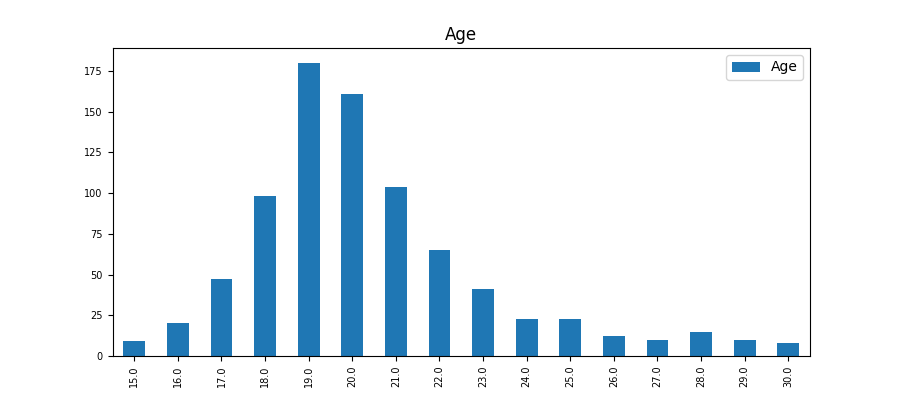

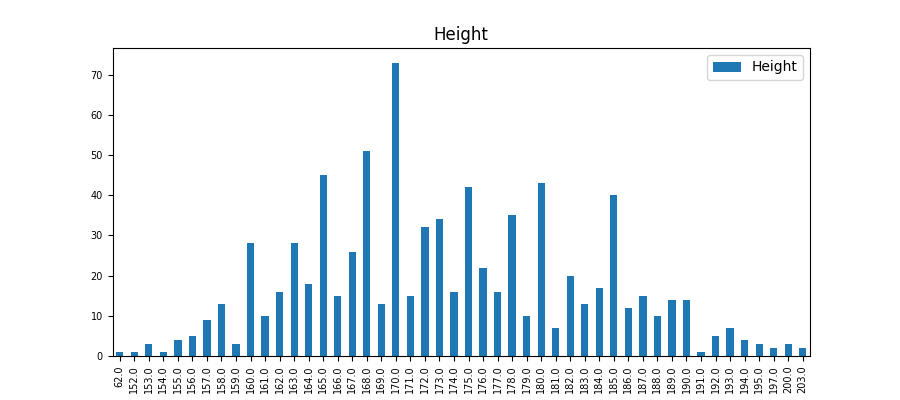

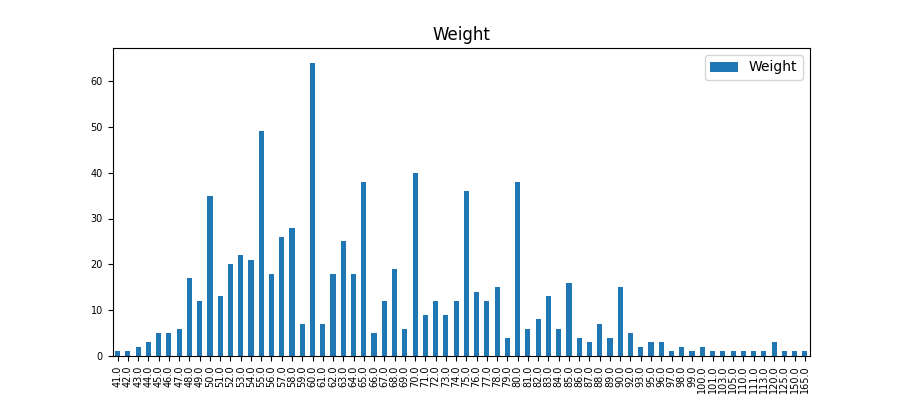

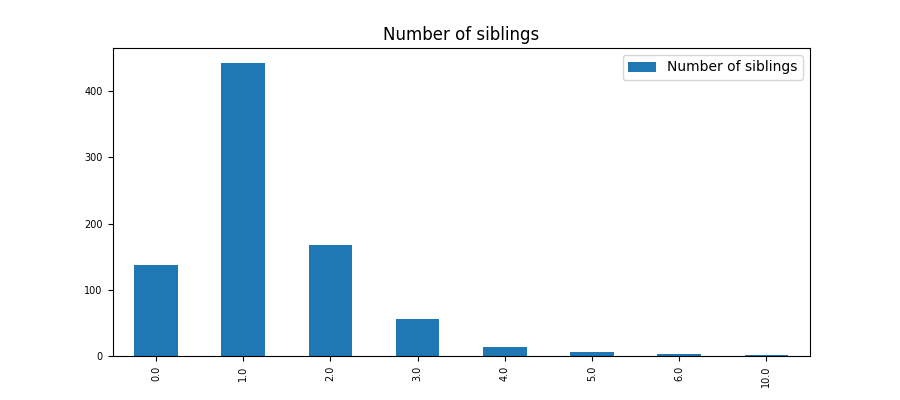

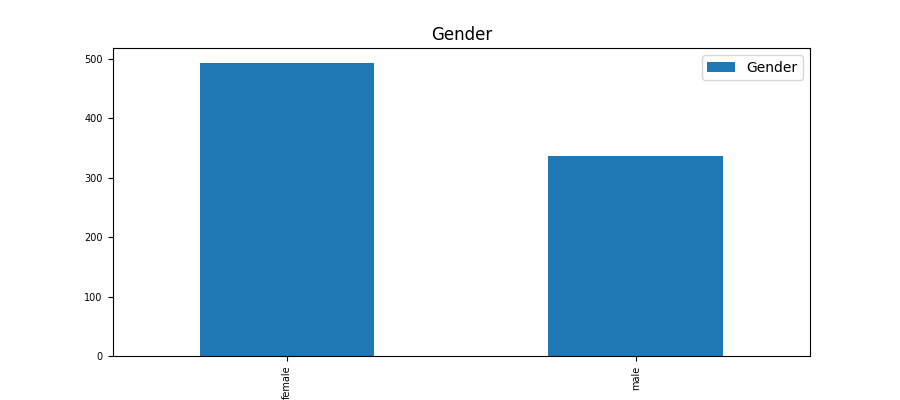

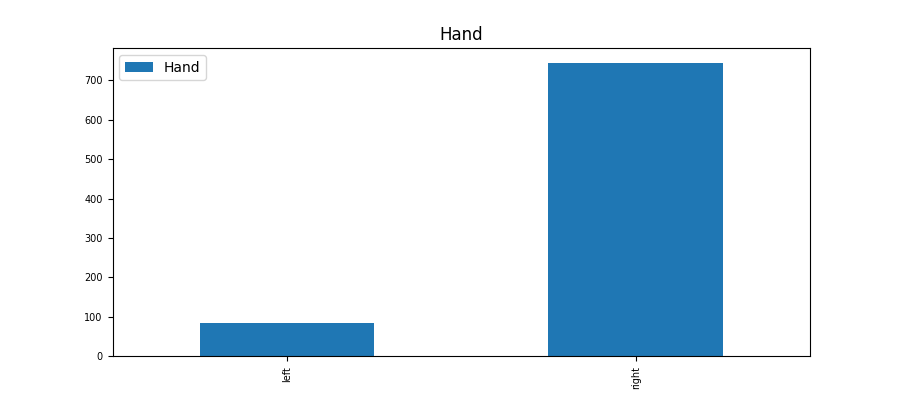

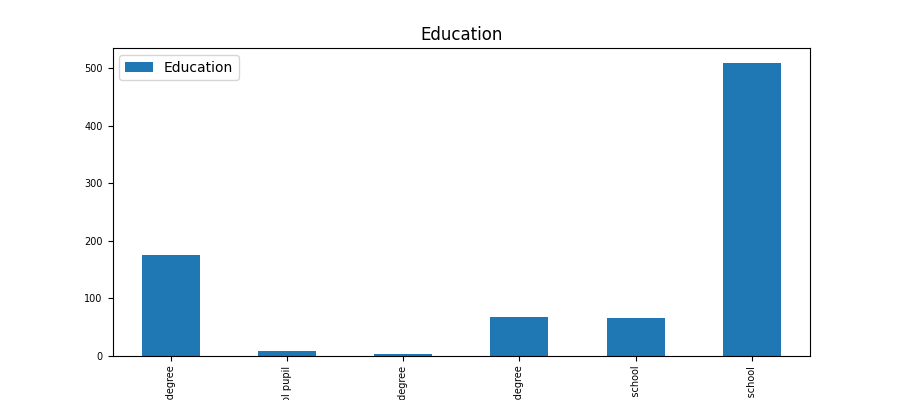

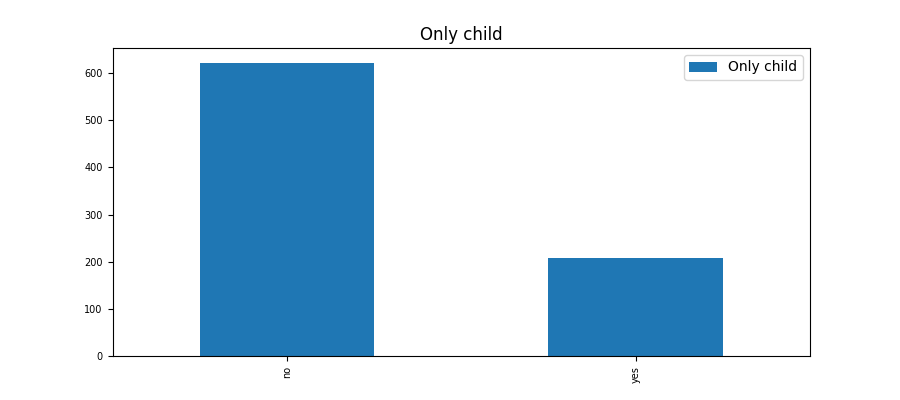

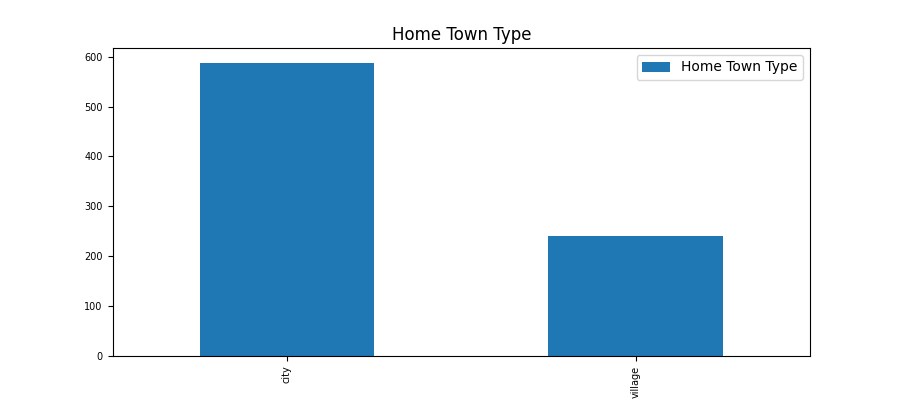

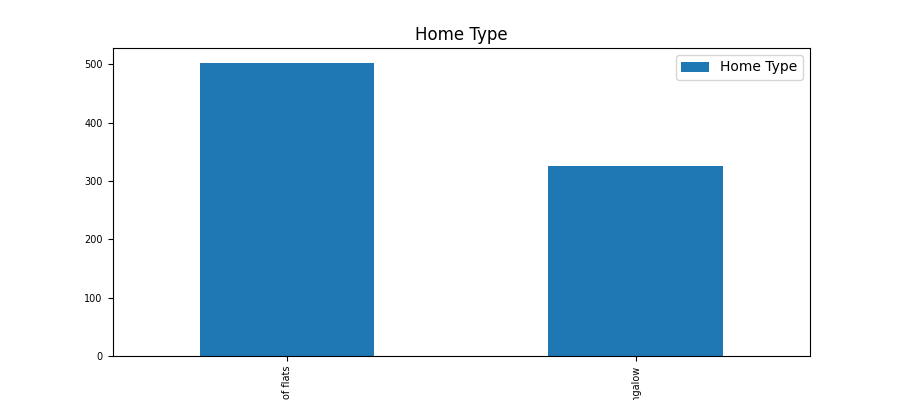

In [25]:
for col in df_demographics_1.columns:
    df_demographics_1.loc[:, [col]].apply(pd.value_counts).sort_index().plot(kind = 'bar',fontsize = 7, figsize = (9, 4), title = col)

## 7.2 Internal Evaluation

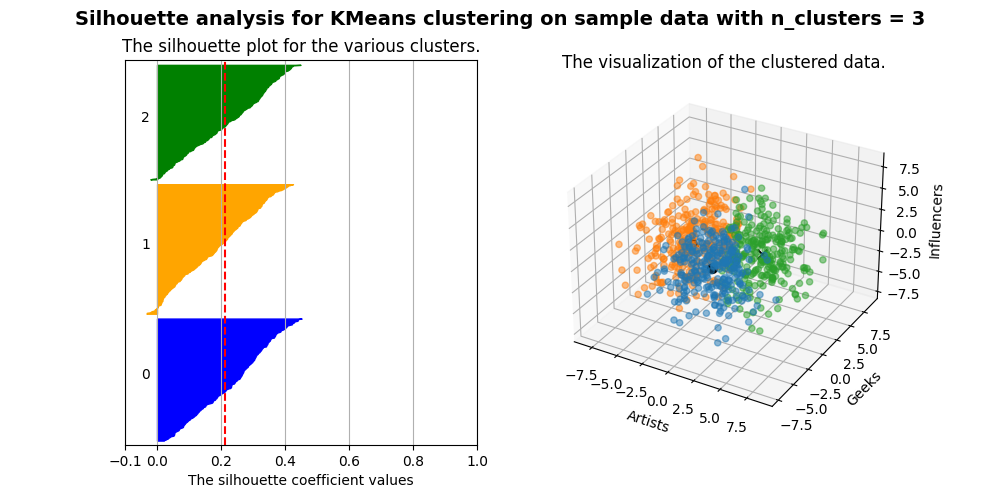

In [26]:
plt.figure(figsize=(10,5)) 
ax1 = plt.subplot(1, 2, 1) 
     
# Range ax1 plot 
ax1.set_xlim([-0.1, 1]) 
ax1.set_ylim([0, len(Y_1) + (n_clusters + 1) * 10]) 
 
cluster_labels = km.labels_ 
silhouette_avg = silhouette_score(Y_1, cluster_labels) 
 
# Compute the silhouette scores for each sample 
sample_silhouette_values = silhouette_samples(Y_1, cluster_labels) 
 
# Start height of the plot  
y_lower = 10 
 
for i in range(n_clusters): 
    # Silhouette values for each element and then sort 
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i] 
    ith_cluster_silhouette_values.sort() 
     
    # Height for the ith-cluster 
    size_cluster_i = ith_cluster_silhouette_values.shape[0] 
    y_upper = y_lower + size_cluster_i 
 
    # Plot the data with the color of the cluster 
    color = col_dict[i] 
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color) 
 
    # Label the silhouette plots with their cluster numbers at the middle 
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) 
 
    # Start height for next cluster plot 
    y_lower = y_upper + 10 

ax1.set_title("The silhouette plot for the various clusters.") 
ax1.set_xlabel("The silhouette coefficient values") 
ax.set_ylabel("Cluster label") 
 
# The vertical line for average silhouette score of all the values 
ax1.axvline(x=silhouette_avg, color="red", linestyle="--") 
ax1.set_yticks([])  # Clear the yaxis labels / ticks 
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]) 
 
#2nd Plot showing the actual clusters formed 
ax2 = plt.subplot(1,2,2, projection='3d') 
 
ax2.scatter(Y_1[:, 0], Y_1[:, 1], Y_1[:, 2], c=cluster_colors, alpha=0.5) 
 
# Labeling the clusters 
for i in range(n_clusters): 
    ax2.scatter(km.cluster_centers_[i, 0], km.cluster_centers_[i, 1], km.cluster_centers_[i, 2], s=50, c='black', marker = markers_dict[i])     

ax2.set_title("The visualization of the clustered data.") 
ax2.set_xlabel(pc_names_1[0]) 
ax2.set_ylabel(pc_names_1[1]) 
ax2.set_zlabel(pc_names_1[2]) 
 
plt.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters, fontsize=14, fontweight="bold") 
ax1.grid(axis='x') 
plt.show()

## 7.3 External Evaluation

In [27]:
df_demographics_1.columns

Index(['Age', 'Height', 'Weight', 'Number of siblings', 'Gender', 'Hand',
       'Education', 'Only child', 'Home Town Type', 'Home Type'],
      dtype='object')

In [29]:
df_demographics_1 = df_demographics_1[['Age', 'Number of siblings', 'Gender', 'Education', 'Home Town Type', 'Home Type']]
df_demographics_1 = pd.concat((df_demographics_1, workdf_1_na), axis = 1)

In [30]:
df_demographics_1.insert(len(df_demographics_1.columns), column = 'Cluster label', value = km.labels_)

Cluster: 0


C:\Jupyter\lib\site-packages\pandas\plotting\_matplotlib\core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Cluster: 1
Cluster: 2


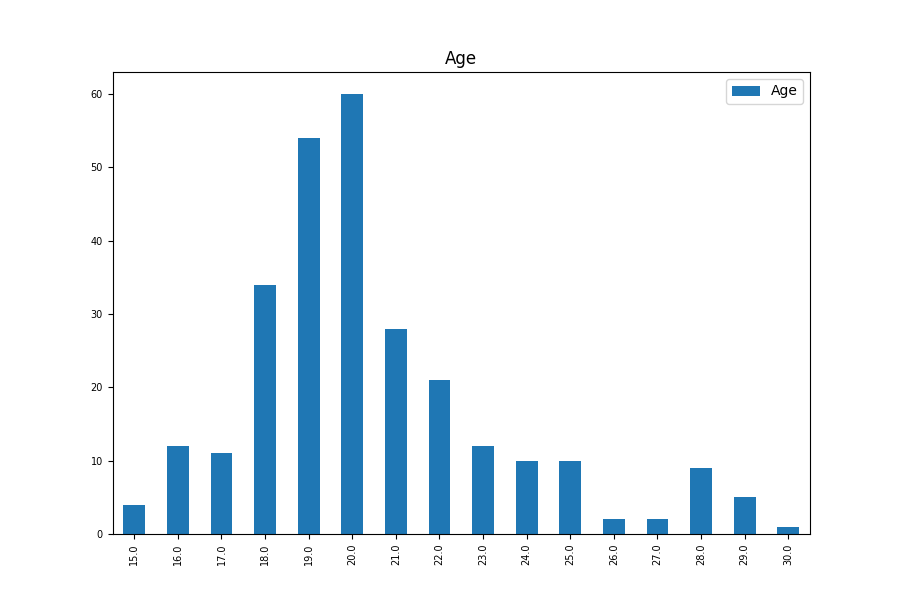

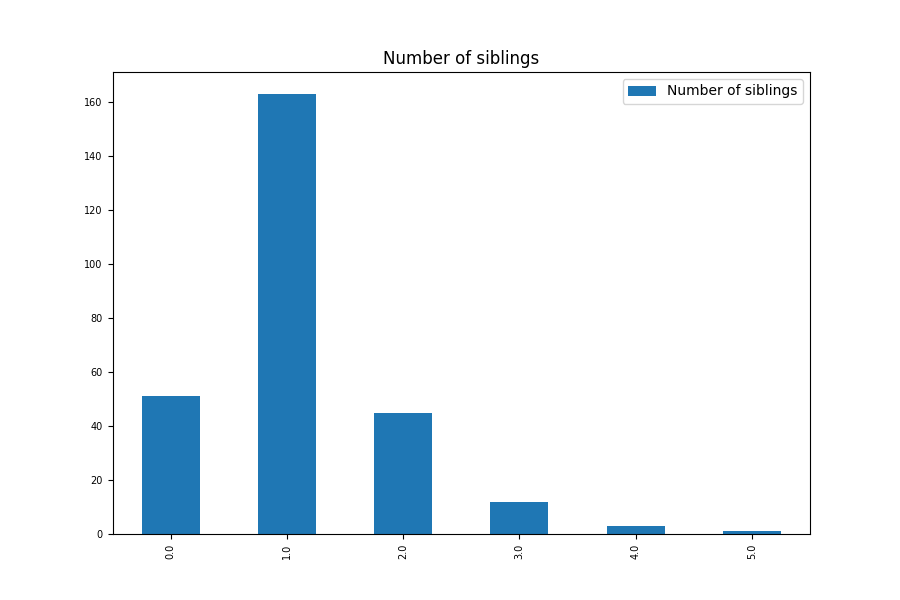

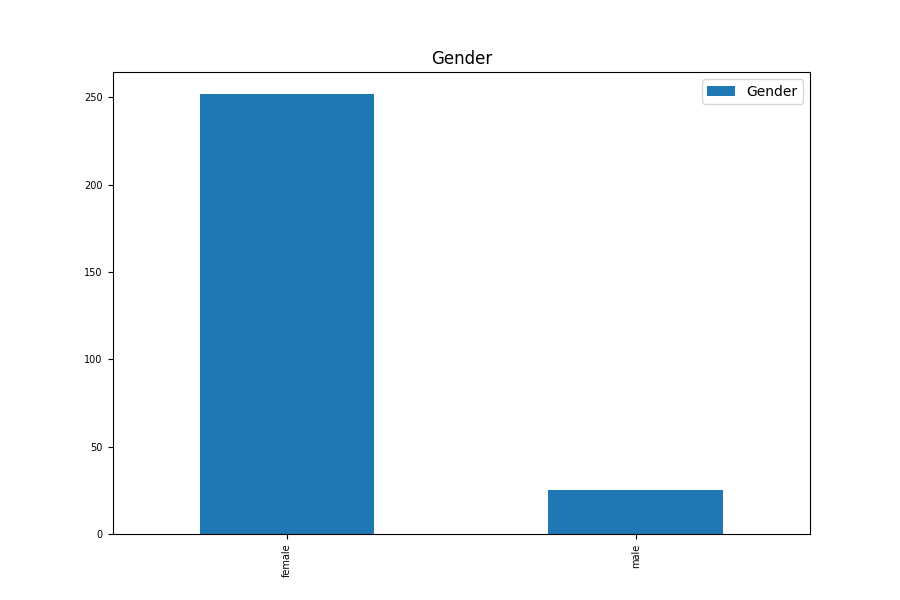

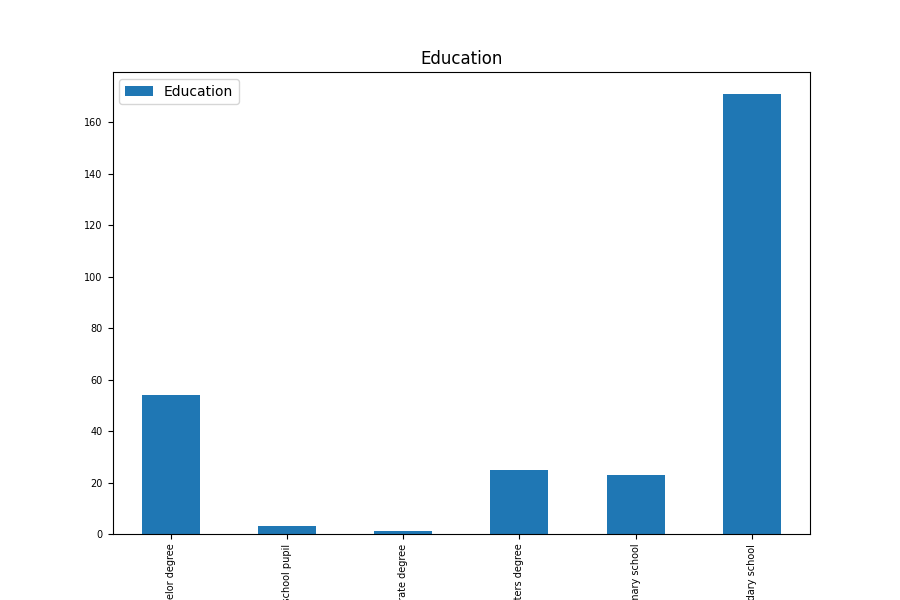

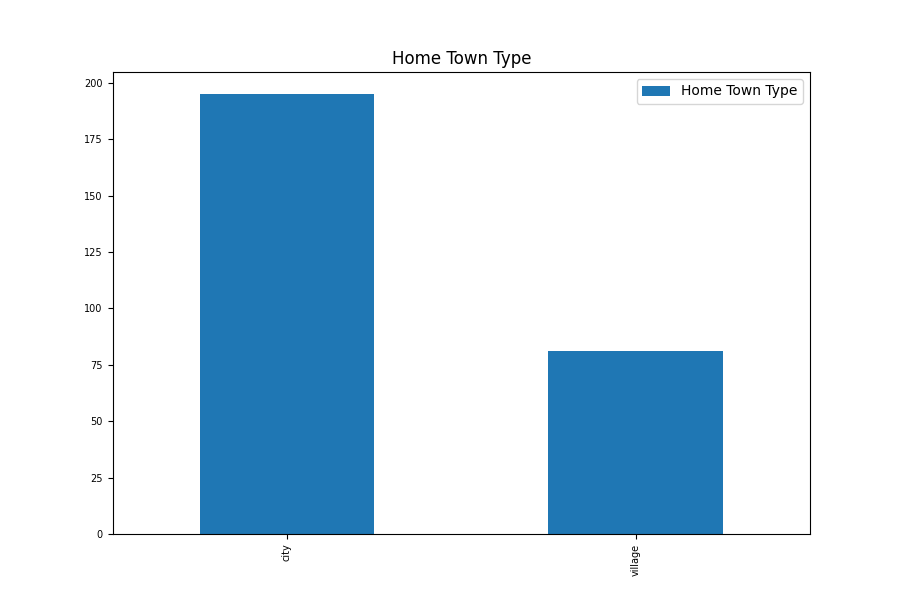

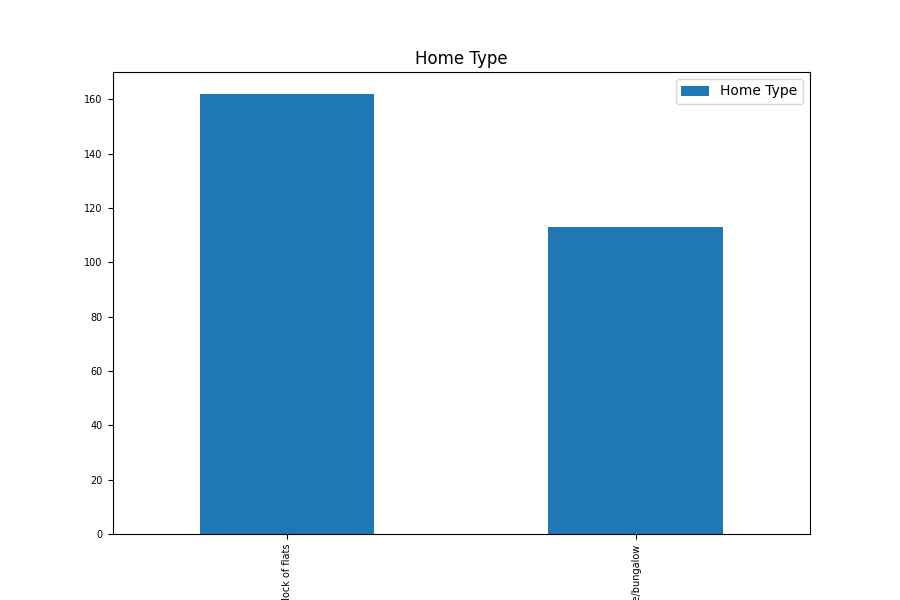

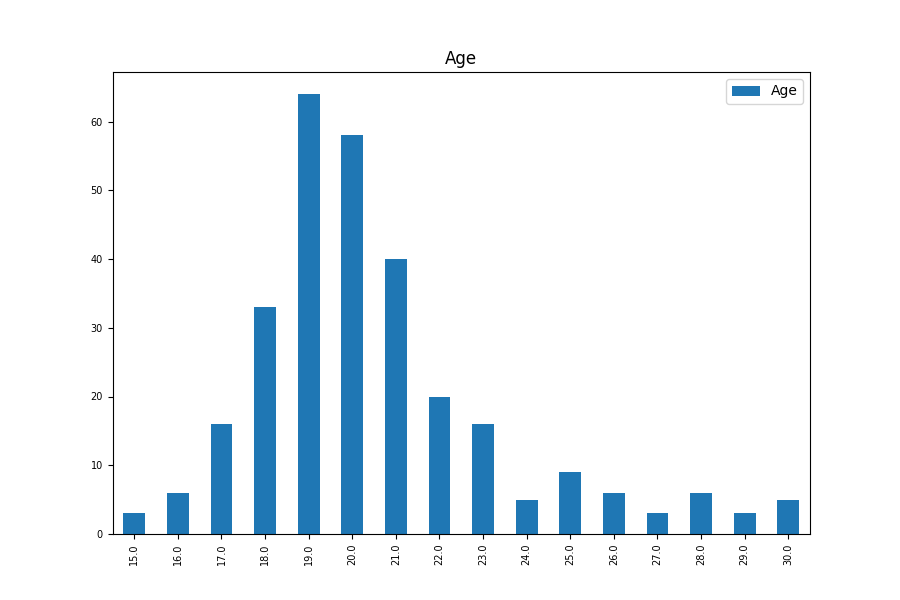

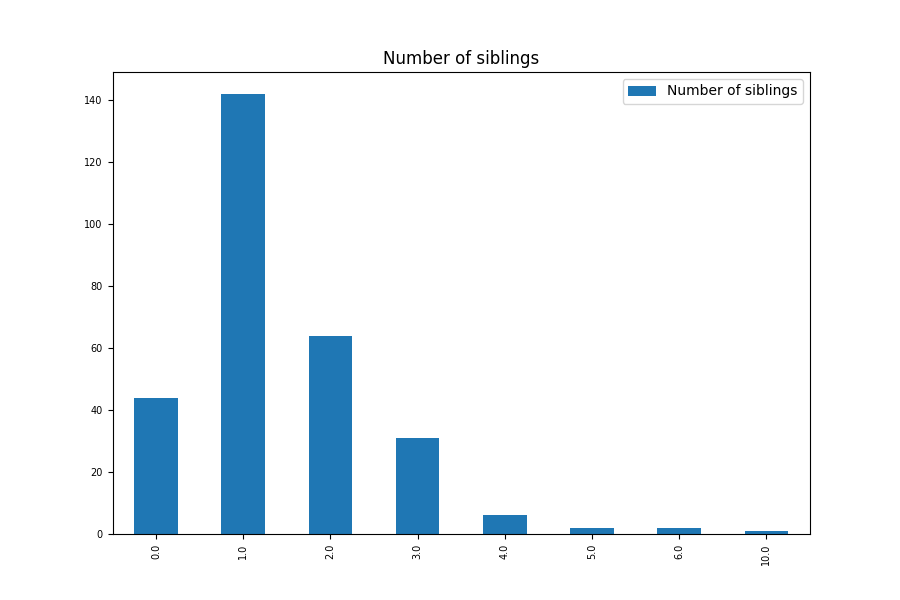

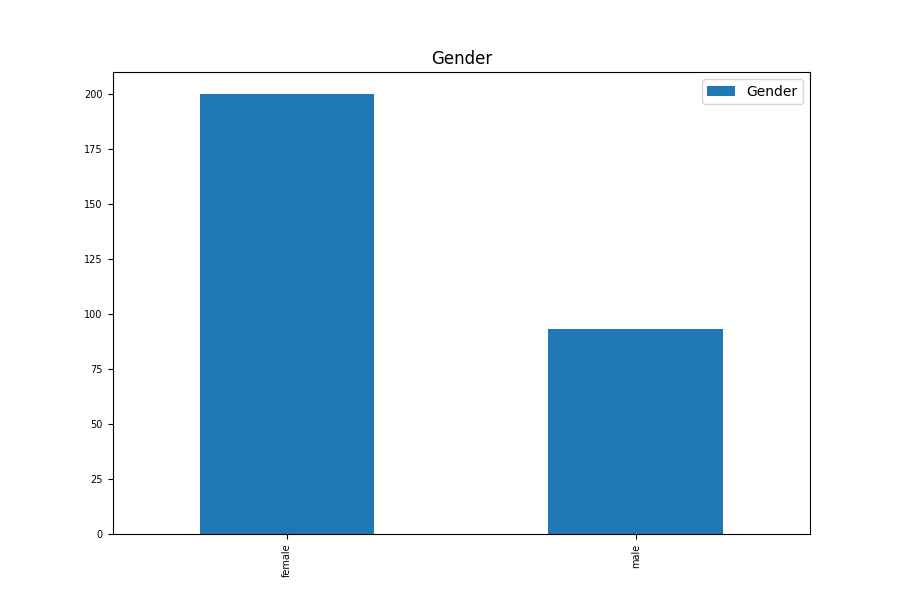

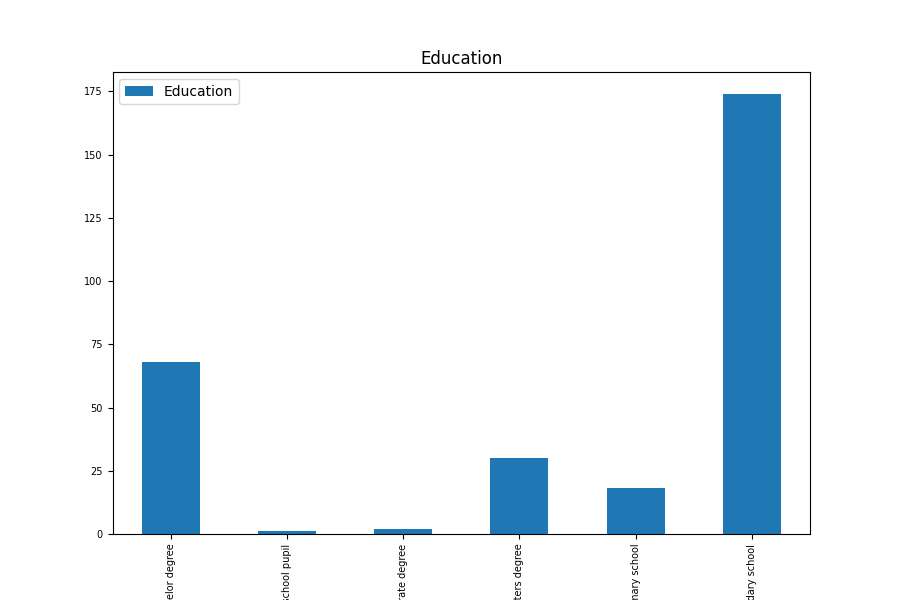

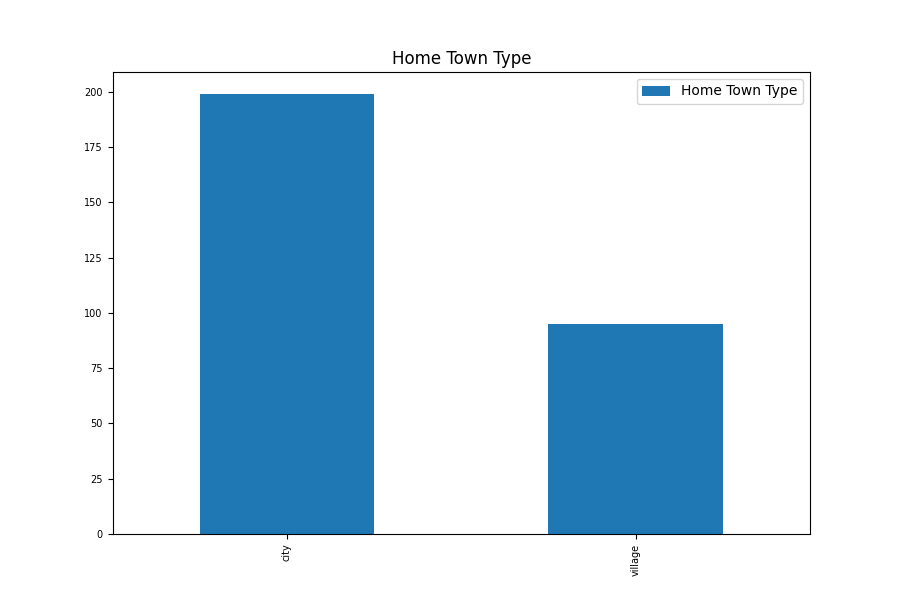

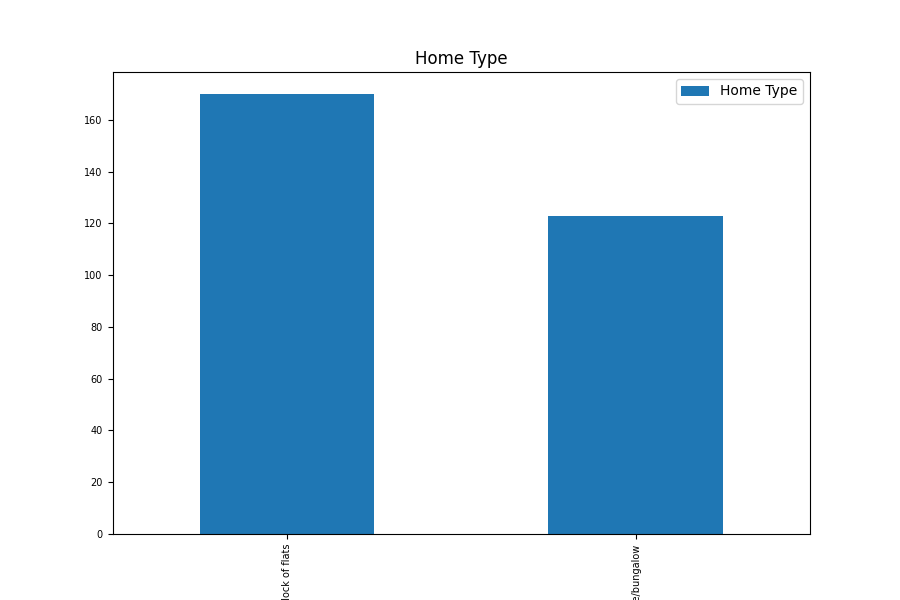

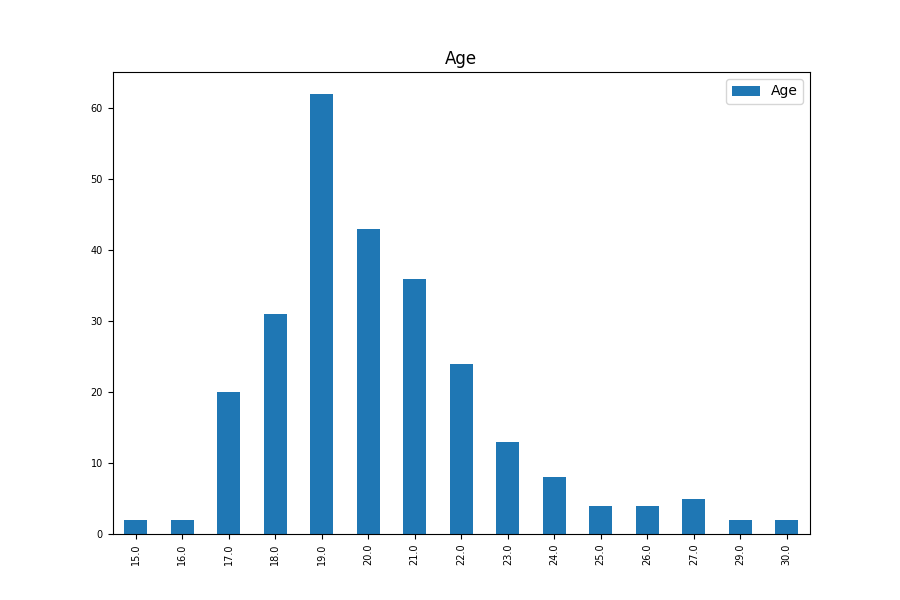

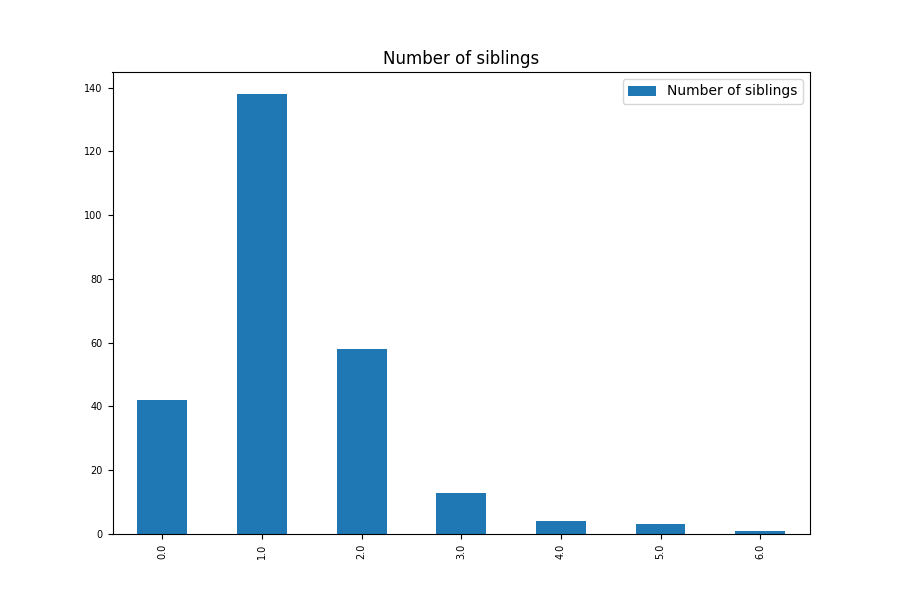

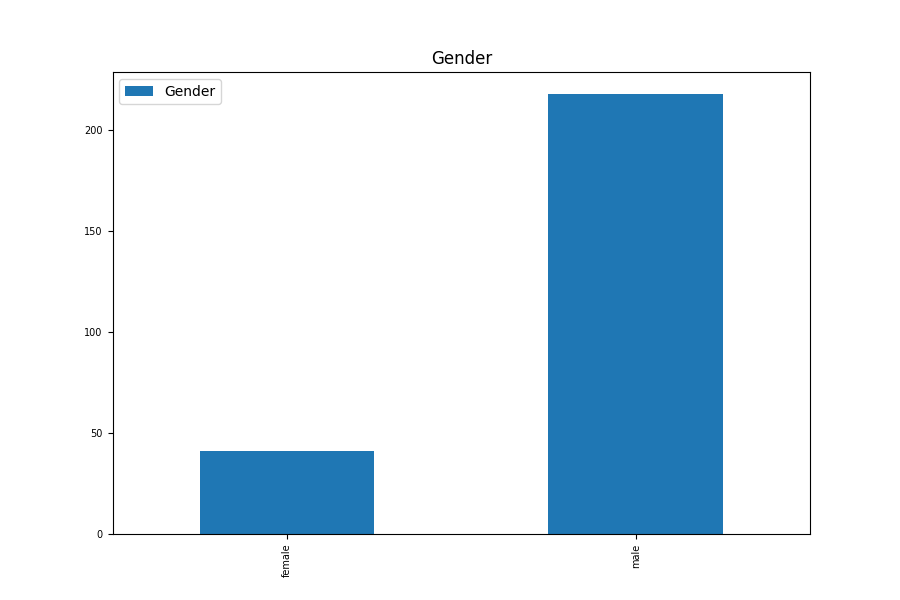

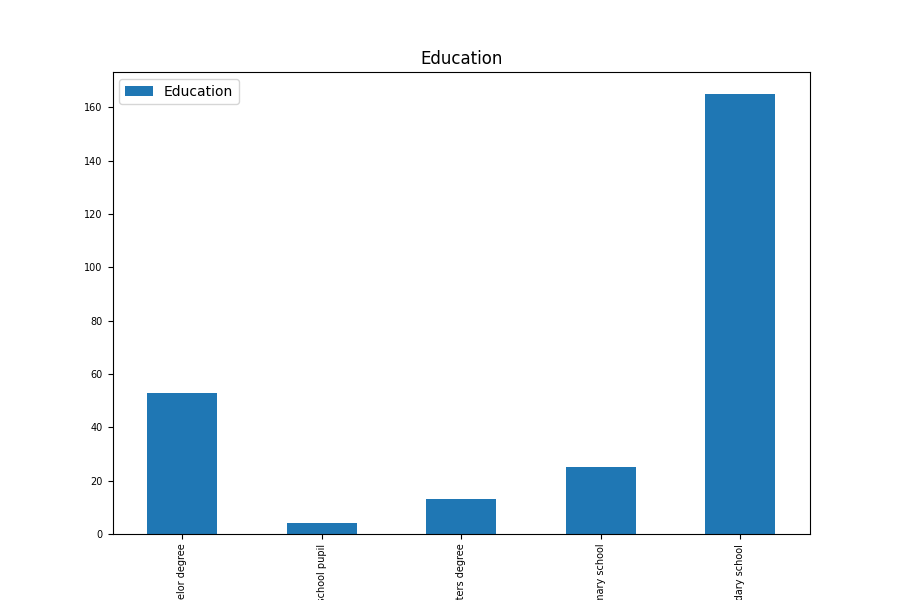

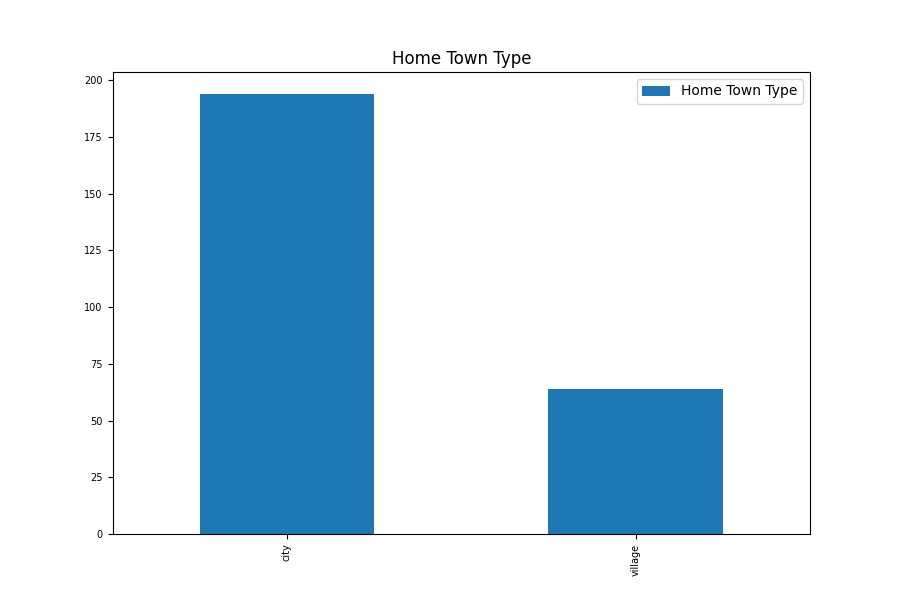

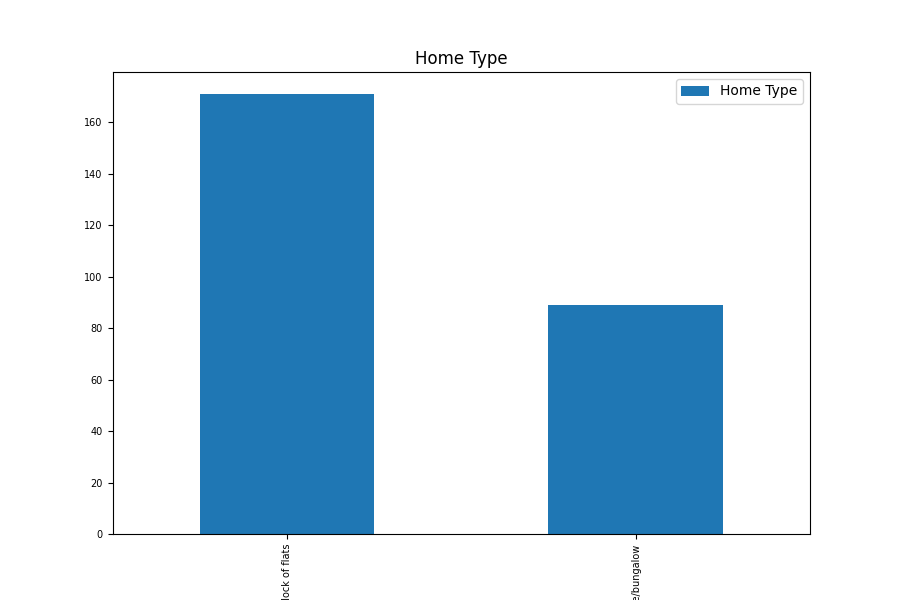

In [32]:
df_cluster = []
df_cluster.append(df_demographics_1[df_demographics_1['Cluster label'] == 0])
df_cluster.append(df_demographics_1[df_demographics_1['Cluster label'] == 1])
df_cluster.append(df_demographics_1[df_demographics_1['Cluster label'] == 2])
print('Cluster: 0')
for col in list(df_cluster[0].columns)[:6]:
    df_cluster[0].loc[:, [col]].apply(pd.value_counts).sort_index().plot(kind = 'bar',fontsize = 7, figsize = (9, 6), title = col)
print('Cluster: 1')
for col in list(df_cluster[1].columns)[:6]:
    df_cluster[1].loc[:, [col]].apply(pd.value_counts).sort_index().plot(kind = 'bar',fontsize = 7, figsize = (9, 6), title = col)
print('Cluster: 2')
for col in list(df_cluster[2].columns)[:6]:
    df_cluster[2].loc[:, [col]].apply(pd.value_counts).sort_index().plot(kind = 'bar',fontsize = 7, figsize = (9, 6), title = col)


# 8 Computation of the PCs

In [33]:
dict_dftot = {"Data with deleted rows" : X_tot_na , "Data with 0 instead of NaN": X_tot_0, "Data with median instead of NaN": X_tot_med}

# aggiungere roba al print
dict_pca_tot = {}
dict_y_tot = {}
for k, v in dict_dftot.items():
    pca = PCA(n_components = 0.3)
    pca.fit(v)
    m = min(pca.n_components_, 6)
    print('Il minimo è', m)
    dict_pca_tot[k] = (PCA(n_components = m))
    dict_pca_tot[k].fit(v)
    dict_y_tot[k] = dict_pca_tot[k].transform(v)
    
    
dict_pca_tot

Il minimo è 6
Il minimo è 6
Il minimo è 6


{'Data with deleted rows': PCA(n_components=6),
 'Data with 0 instead of NaN': PCA(n_components=6),
 'Data with median instead of NaN': PCA(n_components=6)}

In [34]:
for k,v in dict_pca_tot.items():
    recon = v.inverse_transform(dict_y_tot[k])
    print("score di sklearn {} ".format(v.score(dict_dftot[k])))
    rmse = mean_squared_error(dict_dftot[k], recon,squared=False)
    print("RMSE: {} ".format(rmse))

score di sklearn -190.1314019147934 
RMSE: 1.019763145942198 
score di sklearn -192.71491868113216 
RMSE: 1.0441634665589437 
score di sklearn -190.85891019798072 
RMSE: 1.0273410832031478 


In [35]:
pca_tot = dict_pca_tot["Data with deleted rows"]
X_tot = dict_dftot["Data with deleted rows"]
Y_tot = dict_y_tot["Data with deleted rows"]

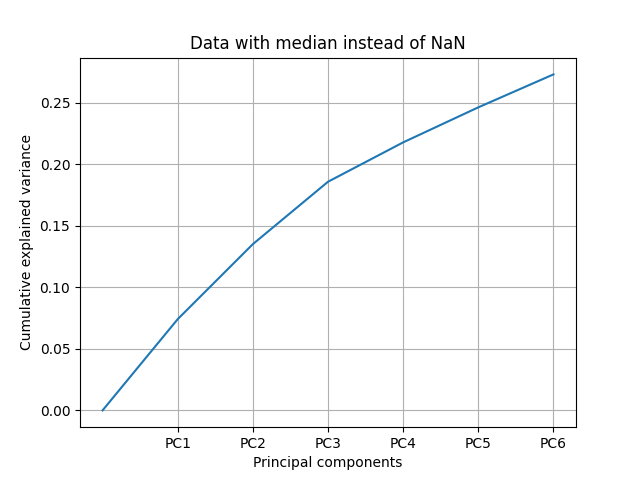

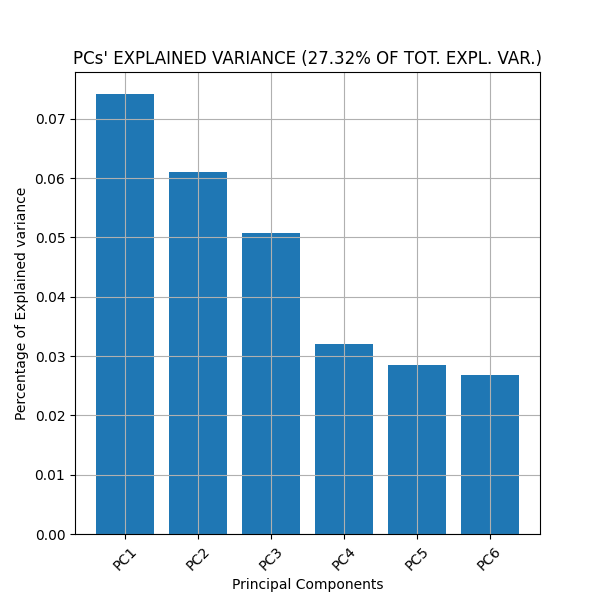

In [36]:
m = pca_tot.n_components
# Curve of cumulative percentage of explained variance
plt.figure()
plt.plot(np.insert(np.cumsum(pca_tot.explained_variance_ratio_), 0, 0))
plt.title(k)
plt.xticks(ticks=np.arange(1, m + 1), 
               labels=[f'PC{i}' for i in range(1, m + 1)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()
    
round_expl_var_ratio = np.round(pca_tot.explained_variance_ratio_.sum() * 100, decimals=2)

# Barplot of percentage of explained variance
plt.figure(figsize=(6, 6))
plt.bar(range(1, m + 1), pca_tot.explained_variance_ratio_)
plt.title(f"PCs' EXPLAINED VARIANCE ({round_expl_var_ratio}% OF TOT. EXPL. VAR.)")
plt.xticks(ticks=np.arange(1, m + 1), 
               labels=[f'PC{i}' for i in range(1, m + 1)],
               rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained variance')
plt.grid()
plt.show()

# 9 Interpretation of the PCs

In [37]:
cat_colors={} 
 
# Colors initialization for Music Preferences 
for el in list(workdf_tot.columns)[:16]: 
    cat_colors[el]= 'tab:blue' 
    
# Colors initialization for Movie Preferences 
for el in list(workdf_tot.columns)[16:28]: 
    cat_colors[el]= 'tab:orange' 

# Colors initialization for Hobbies Interests 
for el in list(workdf_tot.columns)[28:58]: 
    cat_colors[el]= 'tab:green'

# Colors initialization for Phobias
for el in list(workdf_tot.columns)[58:67]: 
    cat_colors[el]= 'tab:purple'
    
# Colors initialization Health Habits 
for el in list(workdf_tot.columns)[67:70]: 
    cat_colors[el]= 'tab:red'
          
# Colors initialization Personality Traits, Views on Life, and Opinions
for el in list(workdf_tot.columns)[70: 119]: 
    cat_colors[el]= 'gold'
    cat_colors={}
    
# Colors initialization for Music Preferences 
for el in list(workdf_tot.columns)[:16]: 
    cat_colors[el]= 'tab:blue' 
    
# Colors initialization for Movie Preferences 
for el in list(workdf_tot.columns)[16:28]: 
    cat_colors[el]= 'tab:orange' 

# Colors initialization for Hobbies Interests 
for el in list(workdf_tot.columns)[28:58]: 
    cat_colors[el]= 'tab:green'

# Colors initialization for Phobias
for el in list(workdf_tot.columns)[58:67]: 
    cat_colors[el]= 'tab:purple'
    
# Colors initialization Health Habits 
for el in list(workdf_tot.columns)[67:70]: 
    cat_colors[el]= 'tab:red'
          
# Colors initialization Personality Traits, Views on Life, and Opinions
for el in list(workdf_tot.columns)[70: 119]: 
    cat_colors[el]= 'gold'
    
# Colors initialization Spending Habits
for el in list(workdf_tot.columns)[119:]: 
    cat_colors[el]= 'turquoise'
    
list_colors = [] 
for k,v in cat_colors.items(): 
    list_colors.append(cat_colors[k])

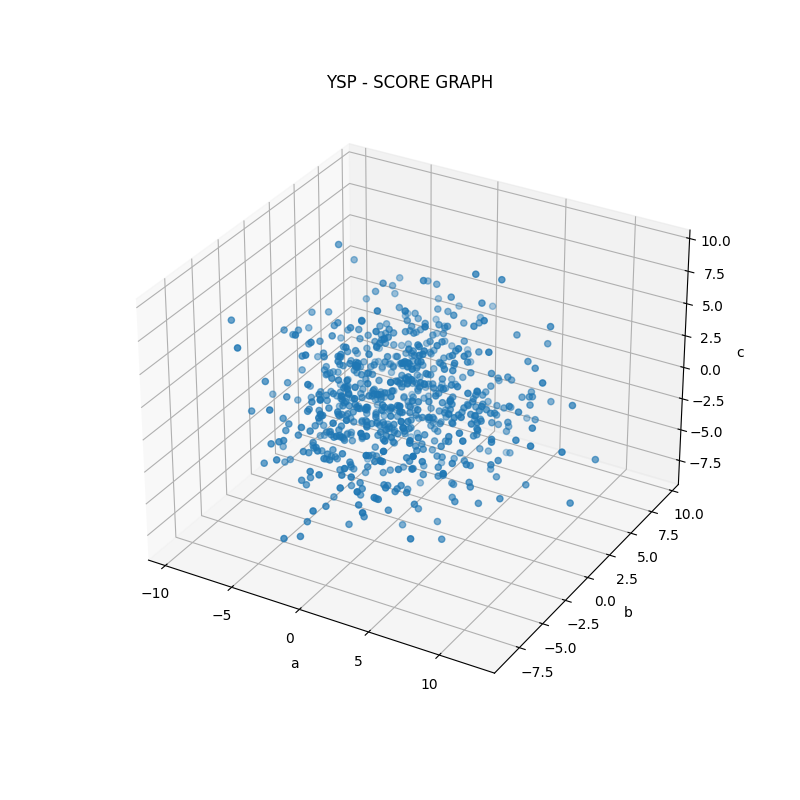

In [38]:
pc_names_tot = ['a', 'b', 'c', 'd', 'e', 'f']
#Score Graph
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y_tot[:, 0], Y_tot[:, 1], Y_tot[:, 2])
plt.title('YSP - SCORE GRAPH')
ax.set_xlabel(pc_names_tot[0])
ax.set_ylabel(pc_names_tot[1])
ax.set_zlabel(pc_names_tot[2])
plt.grid()
plt.show()

# 10 k-Means

In [39]:
# List of values of the hyperparameters 
nclust_list = list(range(3, 11)) 
n_init_list = [3,10] 
iter_list = [300, 500, 1000] 
 
# Dictionarary for the GridSearch  
hparameters = {'n_clusters':nclust_list, 'n_init':n_init_list, 'max_iter':iter_list} 
km = KMeans(random_state=rs) 
 
# Defining the silohutte_scorer fot the GS 
def silhouette_scorer(estimator, X): 
    estimator.fit(X) 
    cluster_labels = estimator.labels_ 
    num_labels = len(set(cluster_labels)) 
    num_samples = X.shape[0] 
    if num_labels == 1 or num_labels == num_samples: 
        return -1 
    else: 
        return silhouette_score(X, cluster_labels) 
     
# Setting to none the slice of the cross validation for not using it 
cv = [(slice(None), slice(None))] 
 
km_gs = GridSearchCV(estimator=km, param_grid=hparameters,  
                  scoring=silhouette_scorer, cv=cv, n_jobs=-1) 
km_gs.fit(Y_tot)

# Results of the GridSearch 
display(pd.DataFrame(km_gs.best_params_, index = ['Best Parameters'])) 
print(f'The best silhoutte score is {km_gs.best_score_}')  
df_results = pd.DataFrame(km_gs.cv_results_) 
display(df_results.sort_values(['rank_test_score'], ascending=True).head())

km = KMeans(random_state= rs, max_iter= 300, n_clusters= 3, n_init= 3) 
km.fit(Y_tot) 
silhouette_score(Y_tot, km.labels_)

max_iter  n_clusters  n_init
Best Parameters       300           3       3

The best silhoutte score is 0.1668562139317185


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.038023           0.0         0.081400             0.0   
1        0.172069           0.0         0.198752             0.0   
16       0.047638           0.0         0.090454             0.0   
32       0.046252           0.0         0.091913             0.0   
33       0.165859           0.0         0.205089             0.0   

   param_max_iter param_n_clusters param_n_init  \
0             300                3            3   
1             300                3           10   
16            500                3            3   
32           1000                3            3   
33           1000                3           10   

                                               params  split0_test_score  \
0     {'max_iter': 300, 'n_clusters': 3, 'n_init': 3}           0.166856   
1    {'max_iter': 300, 'n_clusters': 3, 'n_init': 10}           0.166856   
16    {'max_iter': 500, 'n_clusters': 3, 'n_init': 3}           0.166856   
32   {'max_iter': 1000, 'n_clusters': 3, 'n_init': 3}           0.166856   
33  {'max_iter': 1000, 'n_clusters': 3, 'n_init': 10}           0.166856   

    mean_test_score  std_test_score  rank_test_score  
0          0.166856             0.0                1  
1          0.166856             0.0                1  
16         0.166856             0.0                1  
32         0.166856             0.0                1  
33         0.166856             0.0                1

0.1668562139317185

# 11 Centroid Interpretation and Visualization

In [40]:
cluster_colors = []
markers_dict = {0: 'o', 1: '^', 2: 'x'}
col_dict = {0:'blue', 1:'orange', 2:'green'}
# Colors initialization for Music Preferences 
for el in km.labels_: 
    if el == 0:
        cluster_colors.append('tab:blue')
    if el == 1:
        cluster_colors.append('tab:orange')
    if el == 2:
        cluster_colors.append('tab:green')

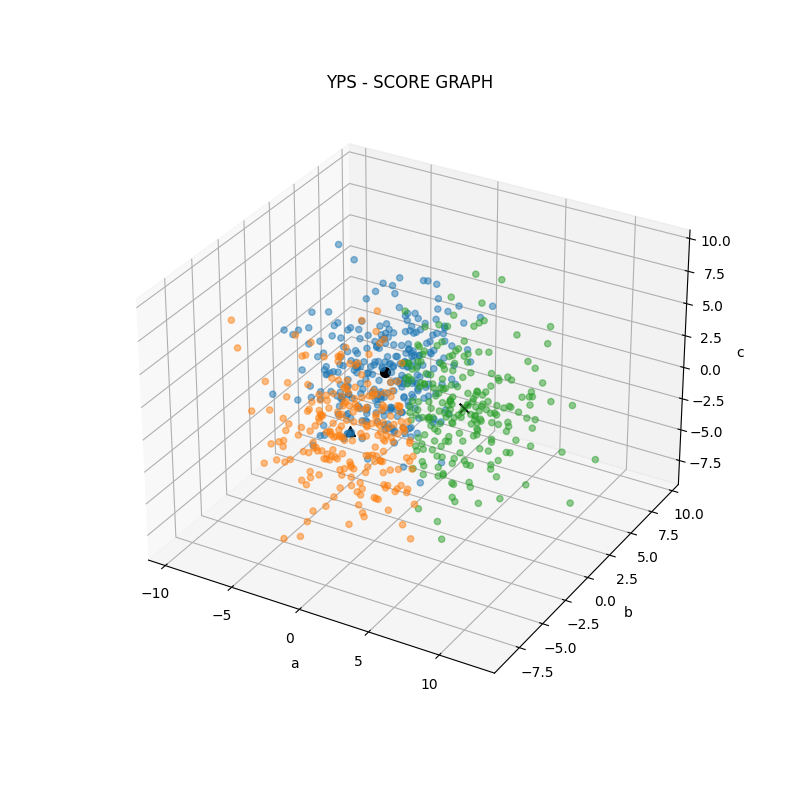

In [41]:
# MAKE THE 3D SCORE GRAPH WITH THE CENTROIDS
sg_3d_km = plt.figure(figsize=(8, 8))
ax_sg_3d_km = sg_3d_km.add_subplot(111, projection='3d')
ax_sg_3d_km.scatter(Y_tot[:, 0], Y_tot[:, 1], Y_tot[:, 2], c=cluster_colors, alpha=0.5)
for i in range(0,3):
    ax_sg_3d_km.scatter(km.cluster_centers_[i, 0], km.cluster_centers_[i, 1], km.cluster_centers_[i, 2],s=50, c='black', marker = markers_dict[i])
plt.title('YPS - SCORE GRAPH')
ax_sg_3d_km.set_xlabel(pc_names_tot[0])
ax_sg_3d_km.set_ylabel(pc_names_tot[1])
ax_sg_3d_km.set_zlabel(pc_names_tot[2])
plt.grid()
plt.show()

In [42]:
pd.DataFrame(data = km.cluster_centers_, columns=pc_names_tot, index = ['First centroid', 'Second Centroid', 'Third Centroid'] )

a         b         c         d         e         f
First centroid  -2.573415  2.306465  0.029773  0.151348 -0.013379 -0.068105
Second Centroid -0.903932 -3.669477 -0.243697 -0.052435  0.147061 -0.036193
Third Centroid   4.227163  0.854617  0.214533 -0.139154 -0.135328  0.124590

# 12 Centroids Evaluation

## 12.1 Distribution of the demographic features into the dataset

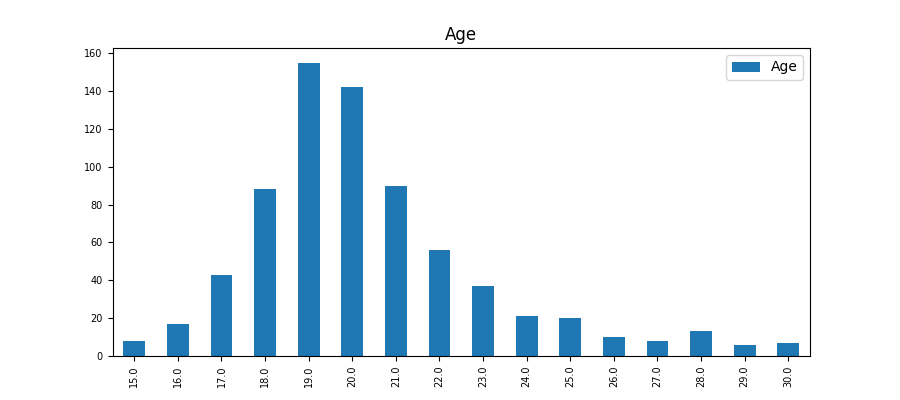

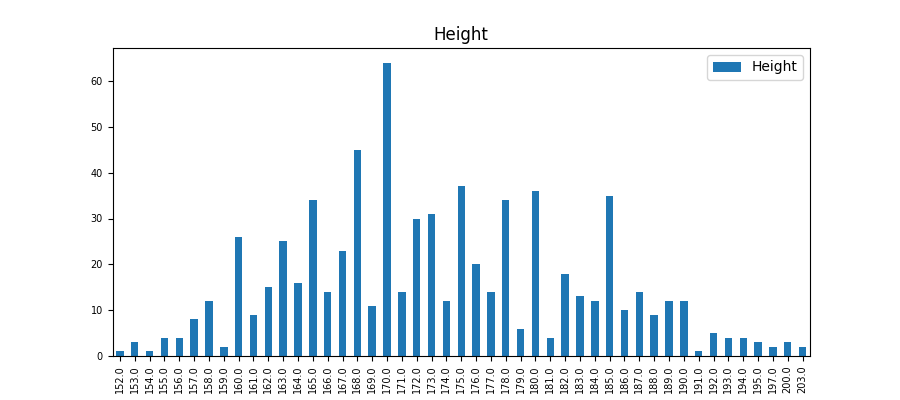

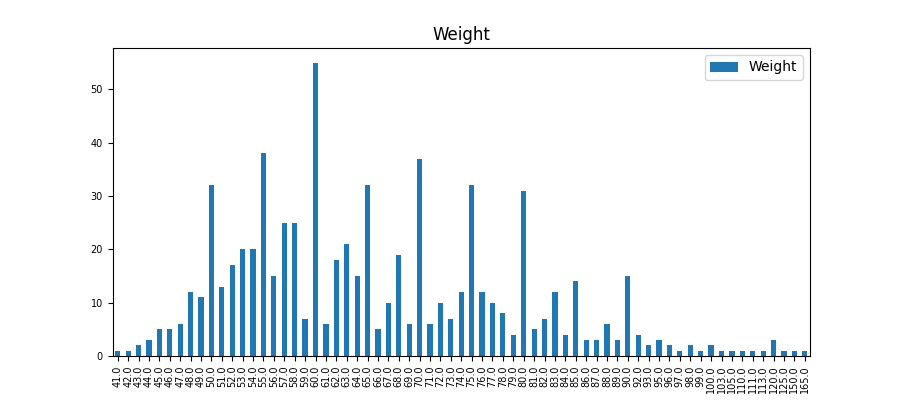

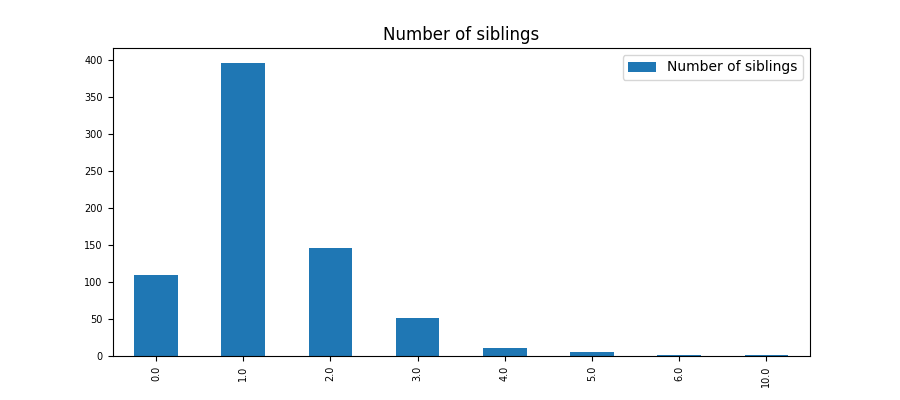

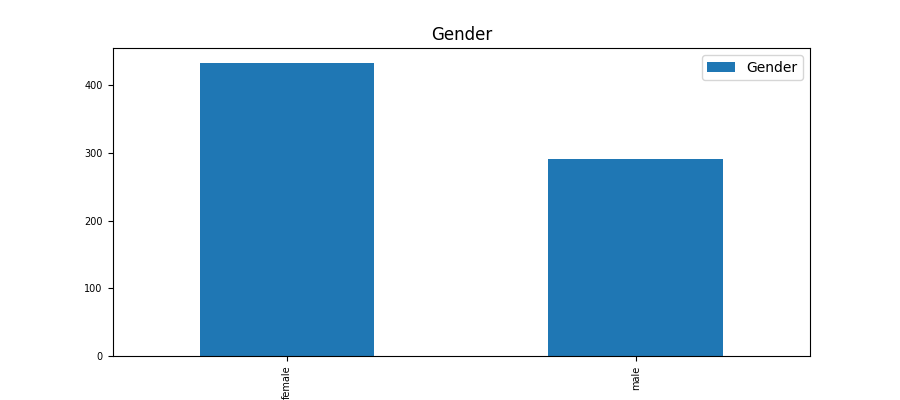

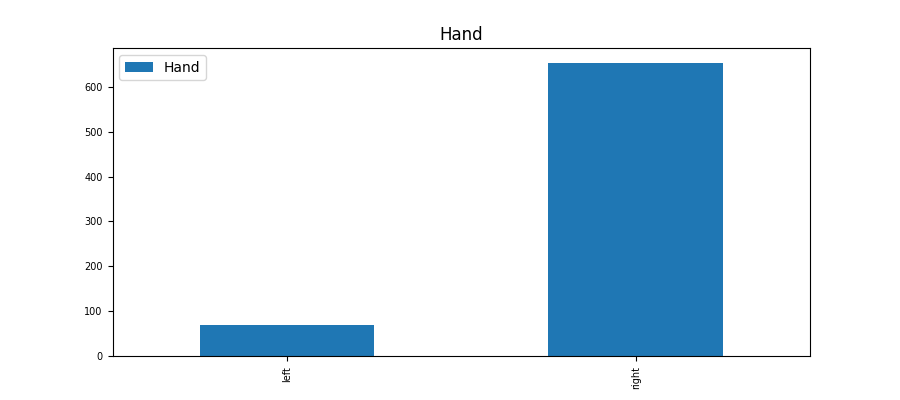

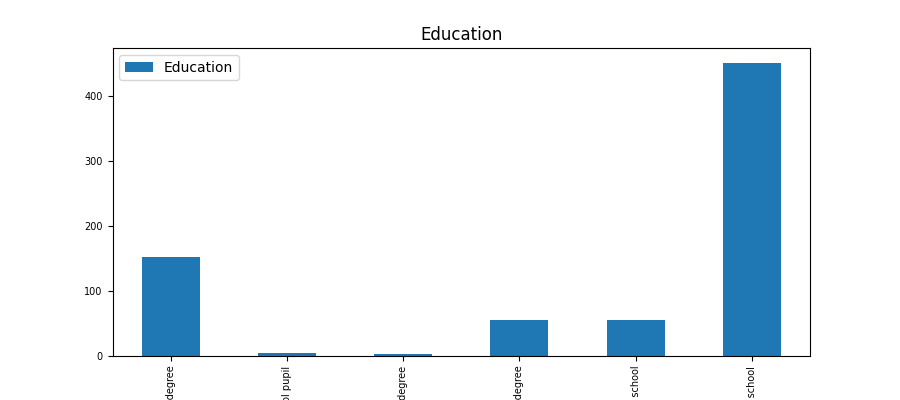

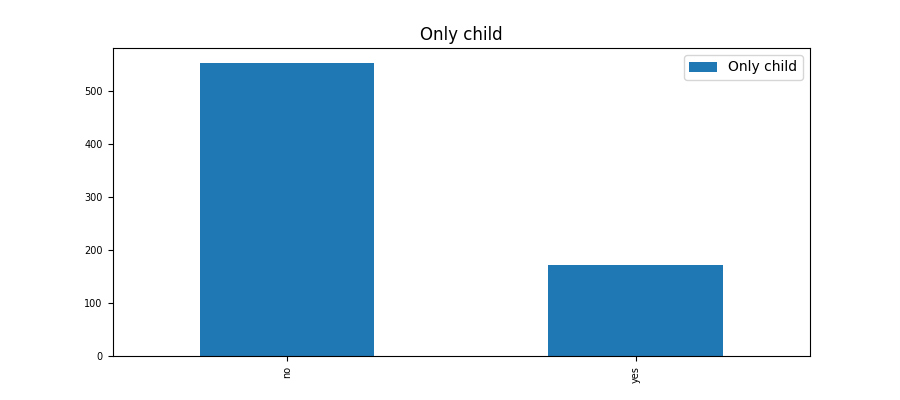

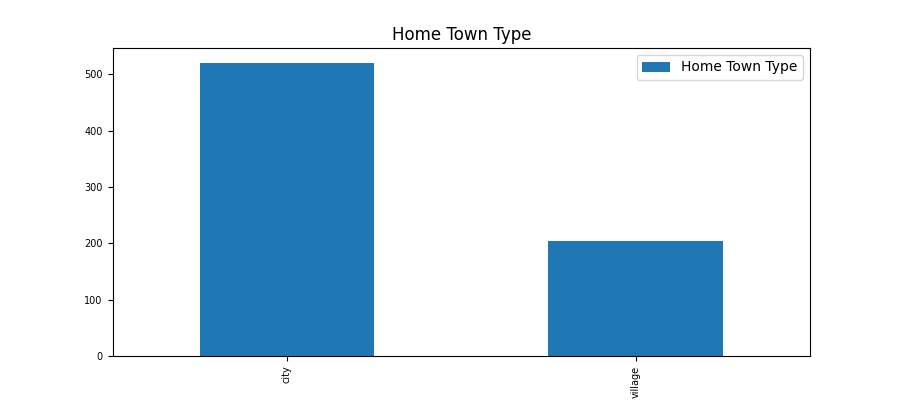

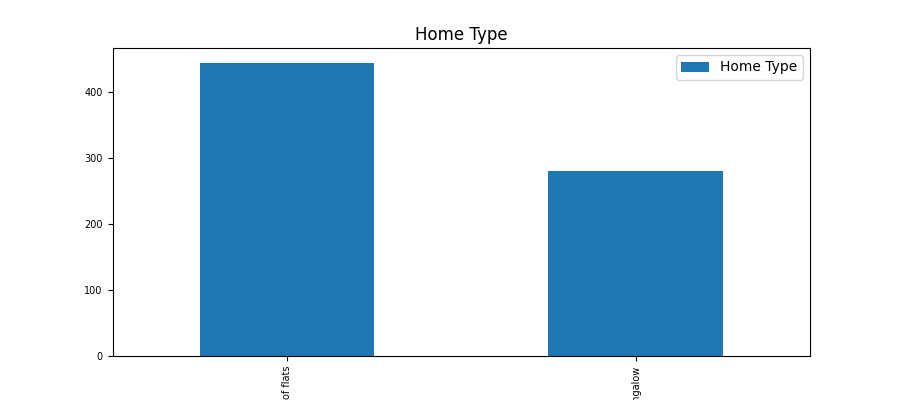

In [43]:
df_demographics_tot = df_demographics.iloc[list(workdf_tot_na.index), :]
for col in df_demographics_tot.columns:
    df_demographics_tot.loc[:, [col]].apply(pd.value_counts).sort_index().plot(kind = 'bar',fontsize = 7, figsize = (9, 4), title = col)

## 12.2 Internal Evaluation

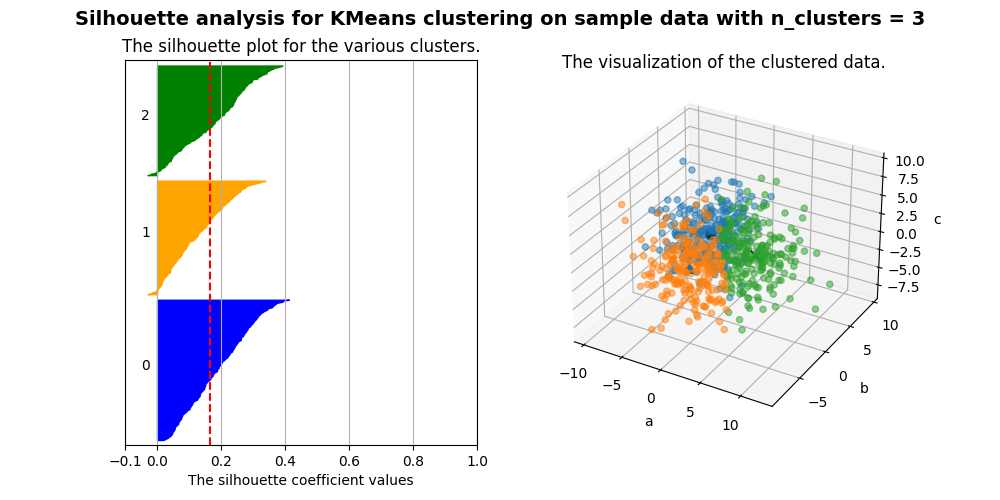

In [44]:
plt.figure(figsize=(10,5)) 
ax1 = plt.subplot(1, 2, 1) 
     
# Range ax1 plot 
ax1.set_xlim([-0.1, 1]) 
ax1.set_ylim([0, len(Y_tot) + (n_clusters + 1) * 10]) 
 
cluster_labels = km.labels_ 
silhouette_avg = silhouette_score(Y_tot, cluster_labels) 
 
# Compute the silhouette scores for each sample 
sample_silhouette_values = silhouette_samples(Y_tot, cluster_labels) 
 
# Start height of the plot  
y_lower = 10 
 
for i in range(n_clusters): 
    # Silhouette values for each element and then sort 
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i] 
    ith_cluster_silhouette_values.sort() 
     
    # Height for the ith-cluster 
    size_cluster_i = ith_cluster_silhouette_values.shape[0] 
    y_upper = y_lower + size_cluster_i 
 
    # Plot the data with the color of the cluster 
    color = col_dict[i] 
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color) 
 
    # Label the silhouette plots with their cluster numbers at the middle 
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) 
 
    # Start height for next cluster plot 
    y_lower = y_upper + 10 

ax1.set_title("The silhouette plot for the various clusters.") 
ax1.set_xlabel("The silhouette coefficient values") 
ax.set_ylabel("Cluster label")
 
# The vertical line for average silhouette score of all the values 
ax1.axvline(x=silhouette_avg, color="red", linestyle="--") 
ax1.set_yticks([])  # Clear the yaxis labels / ticks 
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]) 
 
#2nd Plot showing the actual clusters formed 
ax2 = plt.subplot(1,2,2, projection='3d')
 
ax2.scatter(Y_tot[:, 0], Y_tot[:, 1], Y_tot[:, 2], c=cluster_colors, alpha=0.5) 
 
# Labeling the clusters 
for i in range(n_clusters): 
    ax2.scatter(km.cluster_centers_[i, 0], km.cluster_centers_[i, 1], km.cluster_centers_[i, 2], s=50, c='black', marker = markers_dict[i])     

ax2.set_title("The visualization of the clustered data.") 
ax2.set_xlabel(pc_names_tot[0]) 
ax2.set_ylabel(pc_names_tot[1]) 
ax2.set_zlabel(pc_names_tot[2]) 
 
plt.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters, fontsize=14, fontweight="bold") 
ax1.grid(axis='x') 
plt.show()

## 12.3 External Evaluation

In [45]:
df_demographics_tot = df_demographics_tot[['Age', 'Number of siblings', 'Gender', 'Education', 'Home Town Type', 'Home Type']]
df_demographics_tot = pd.concat((df_demographics_tot, workdf_tot_na), axis = 1)

In [46]:
df_demographics_tot.insert(len(df_demographics_tot.columns), column = 'Cluster label', value = km.labels_)

Cluster: 0
Cluster: 1
Cluster: 2


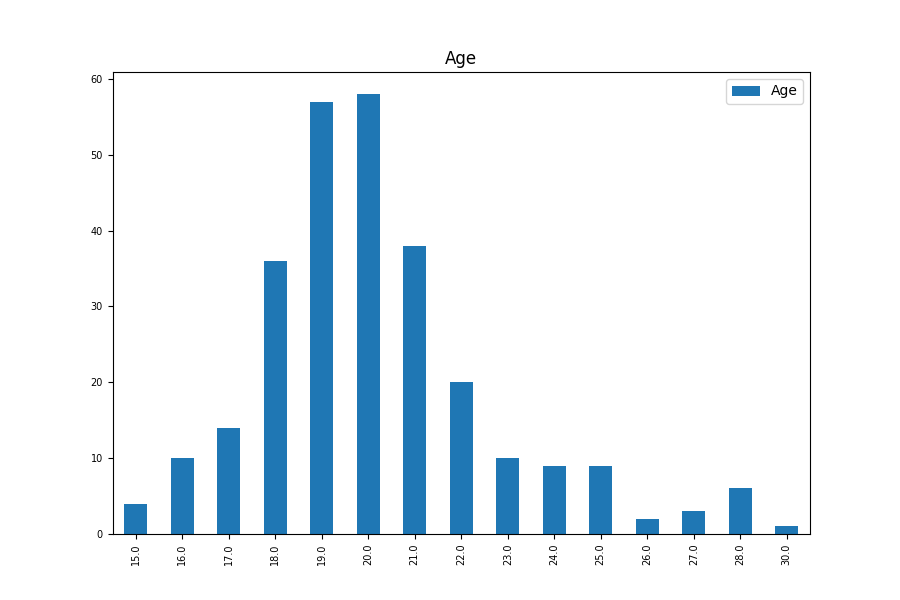

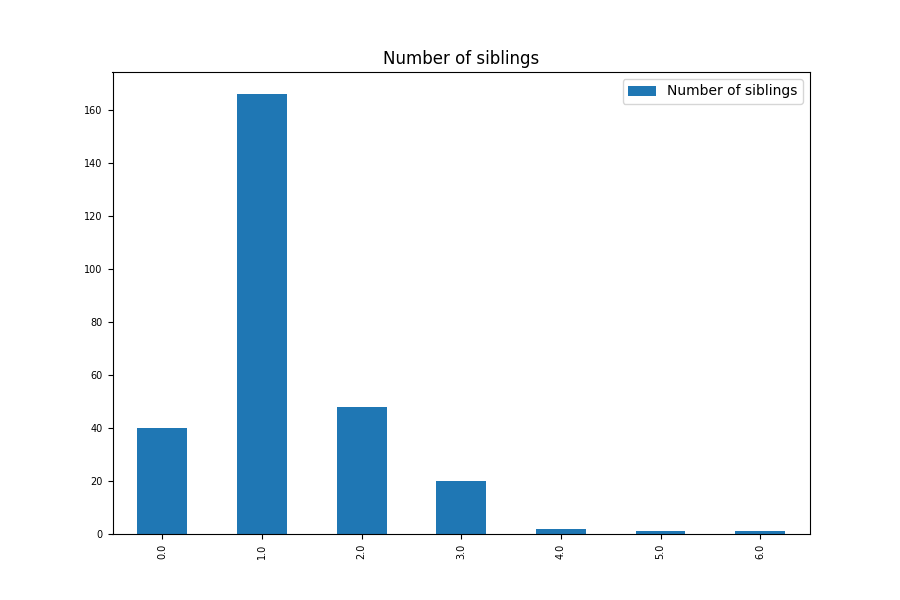

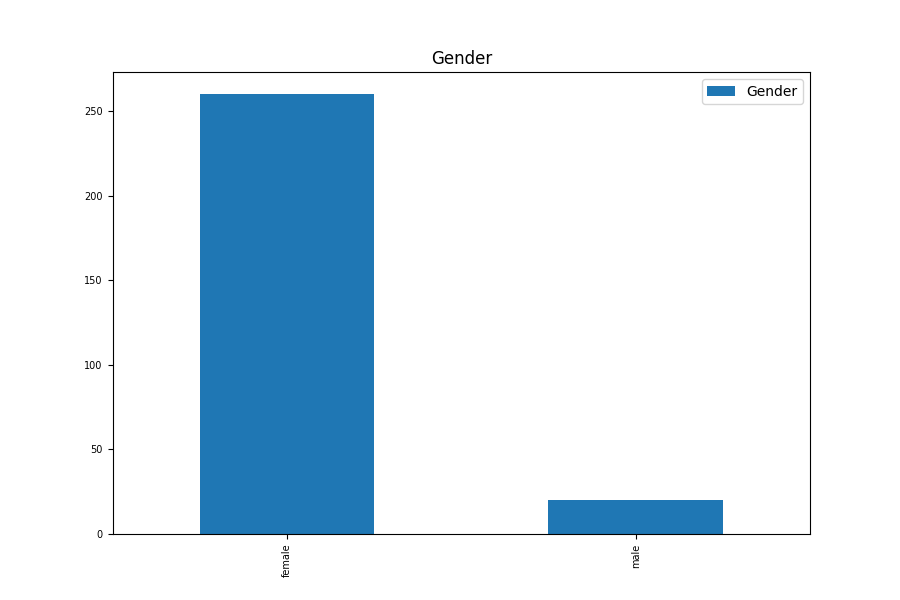

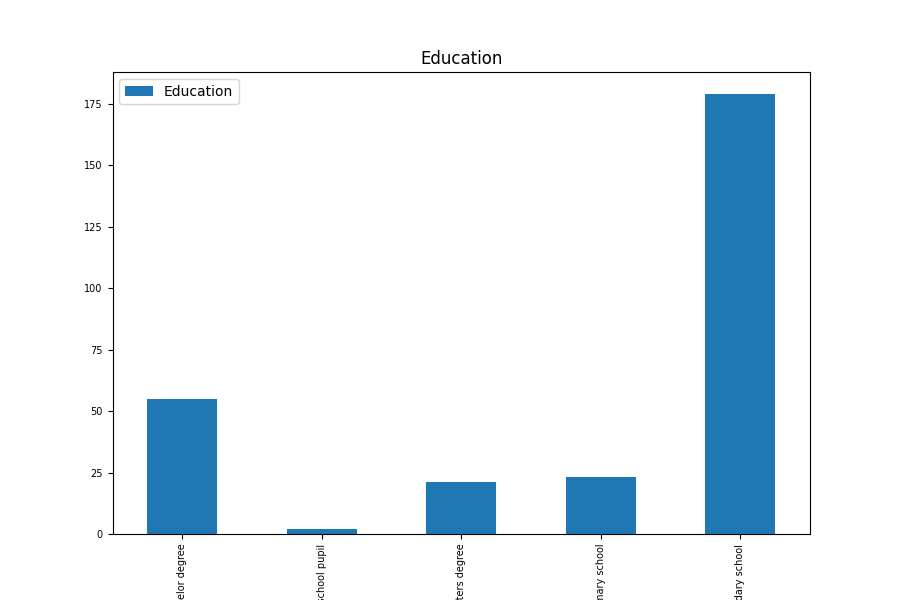

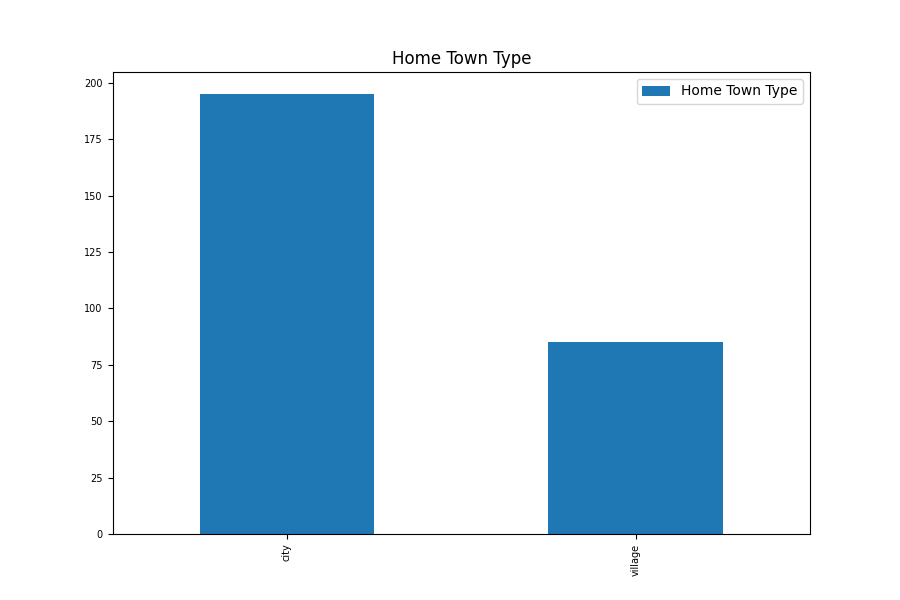

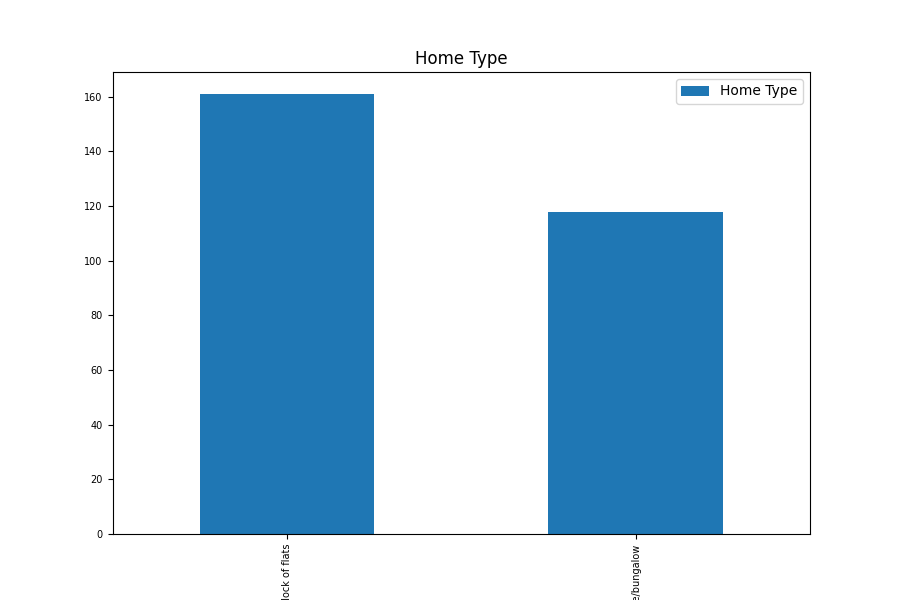

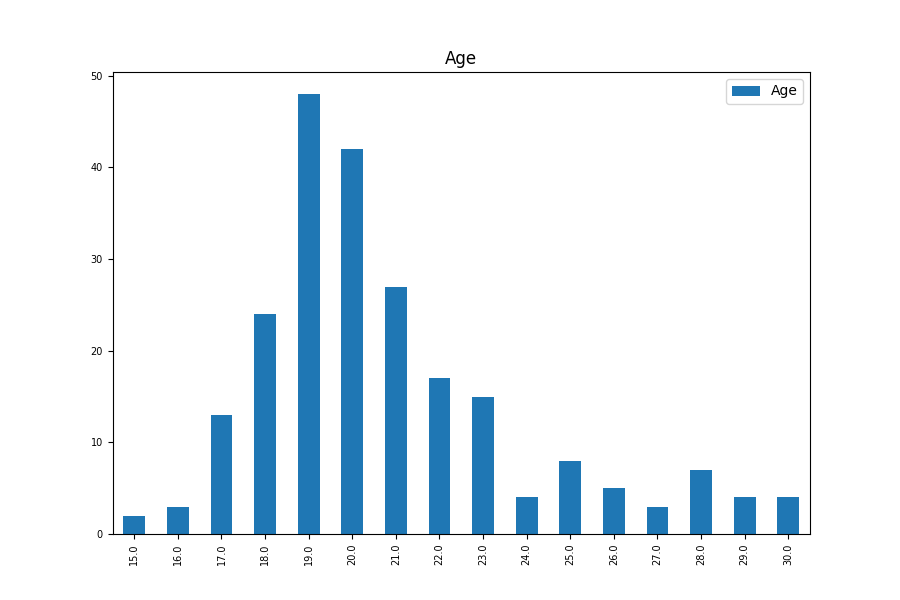

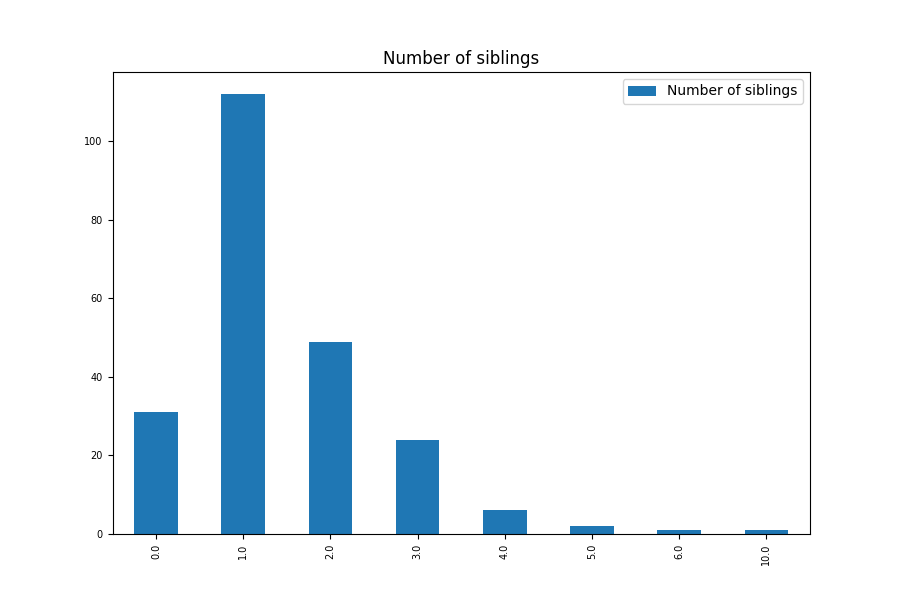

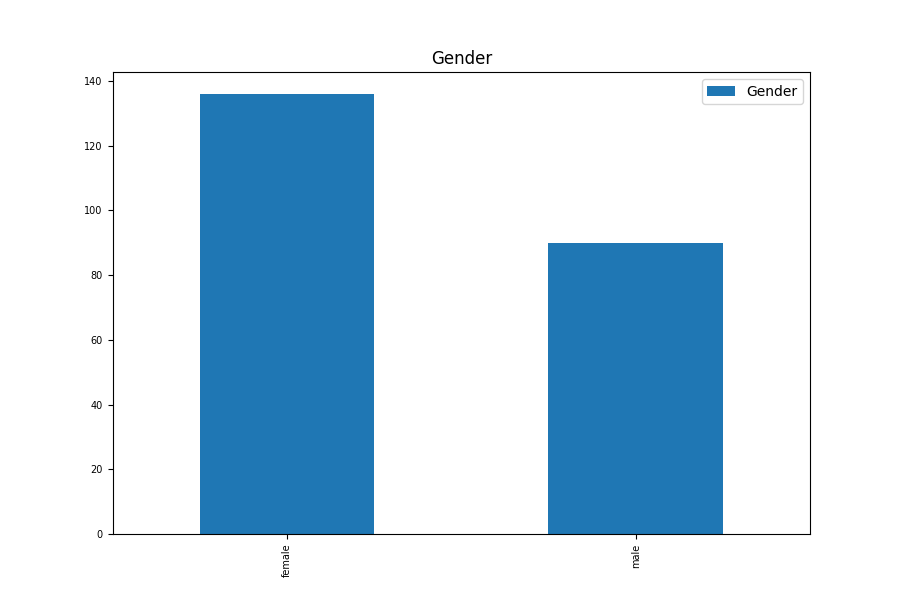

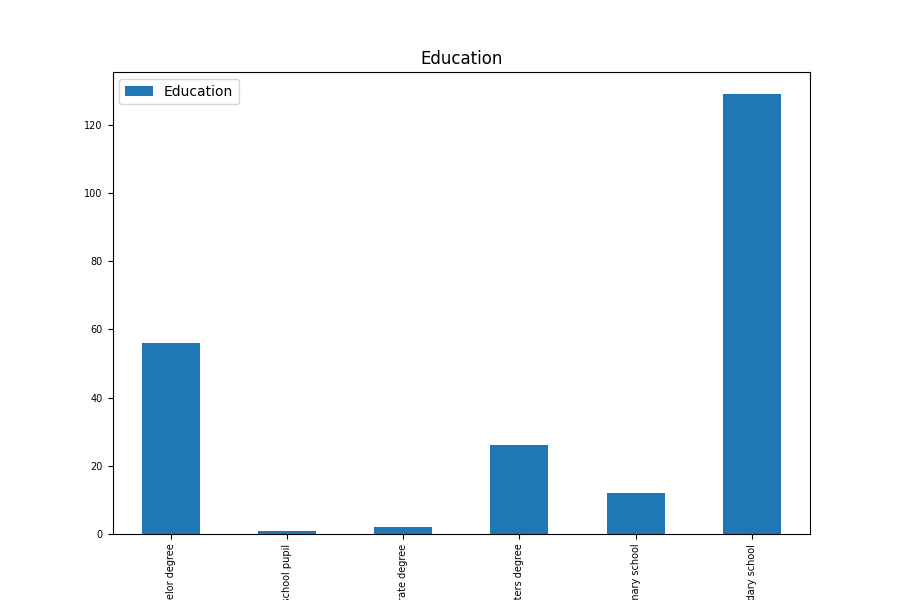

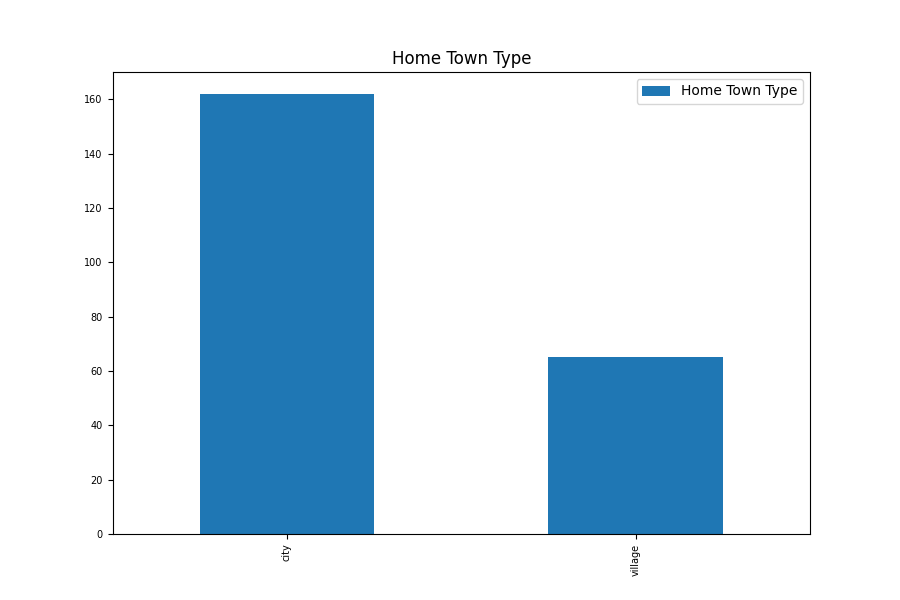

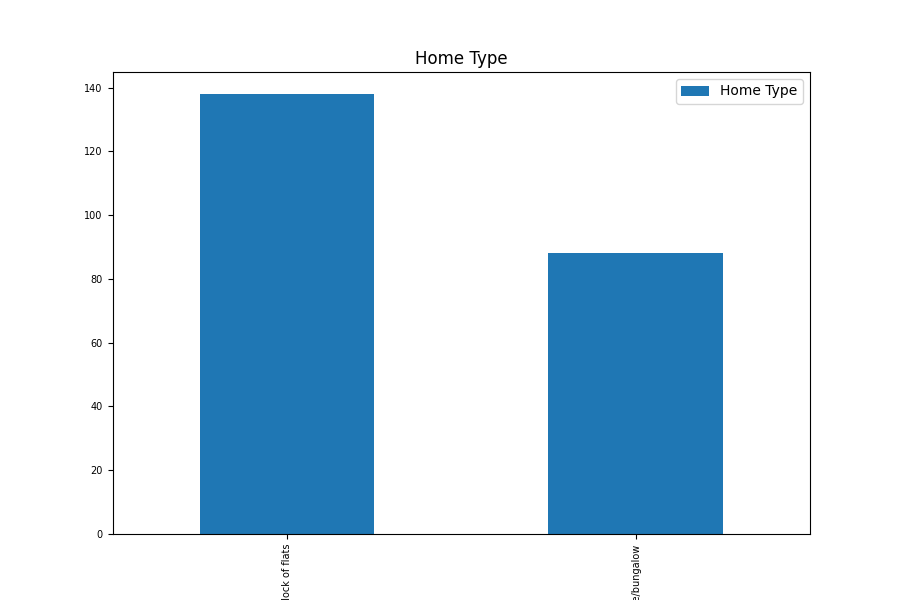

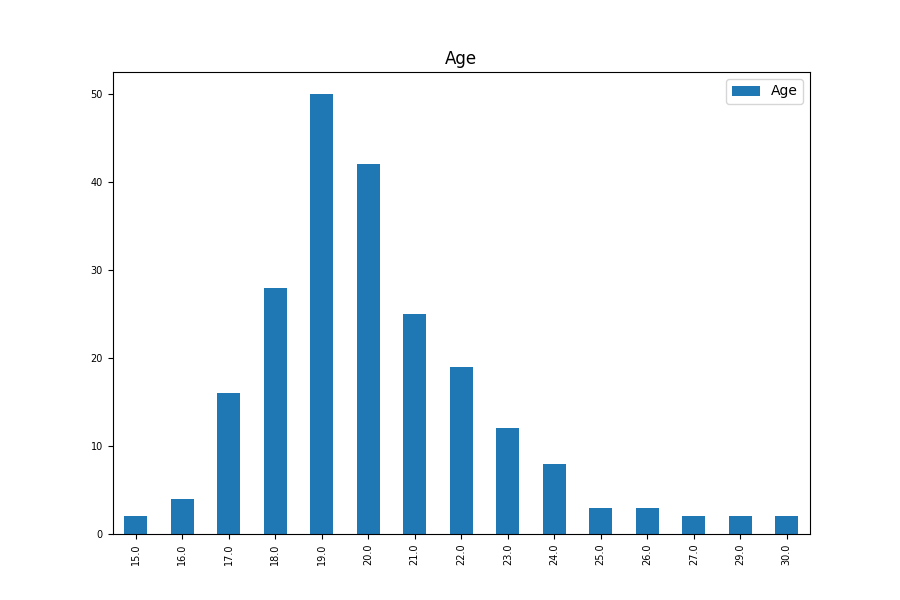

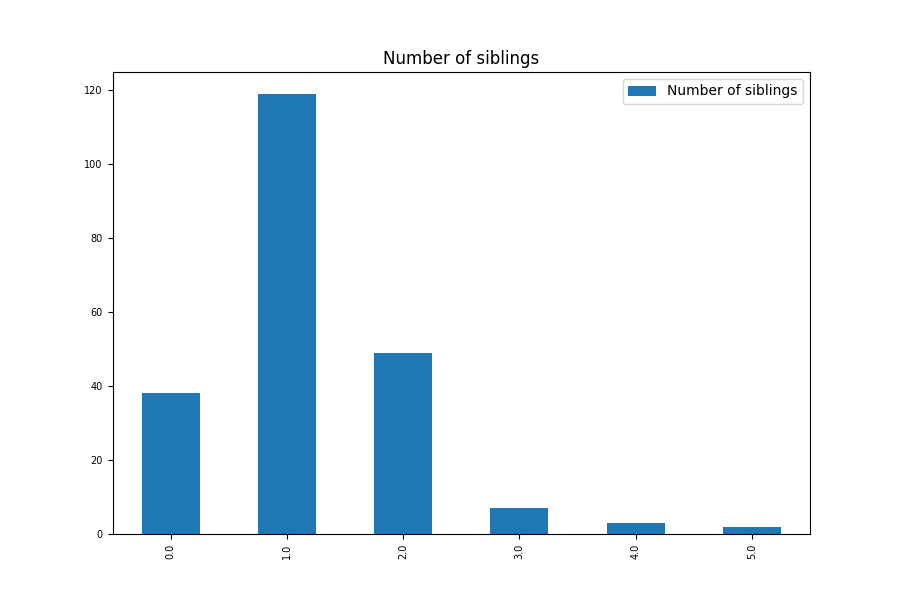

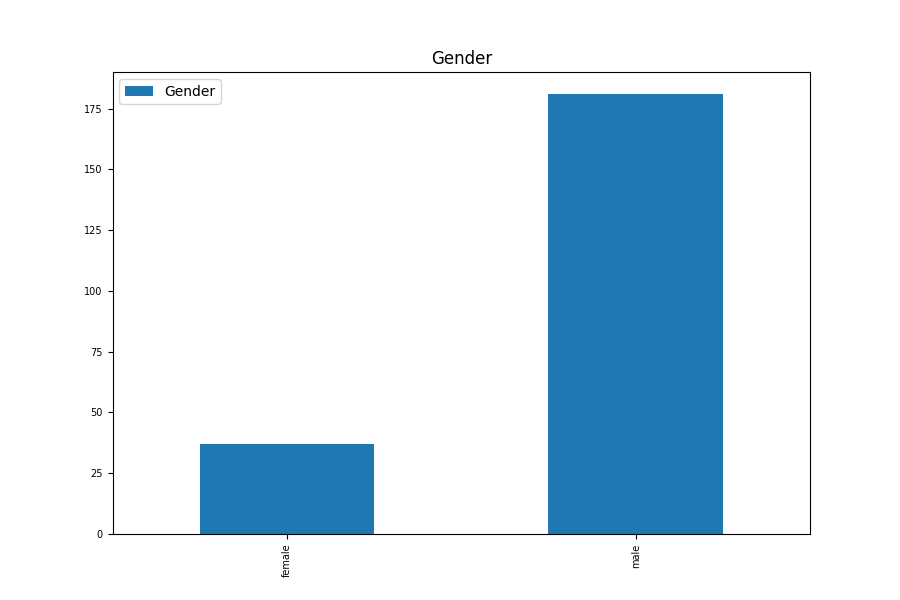

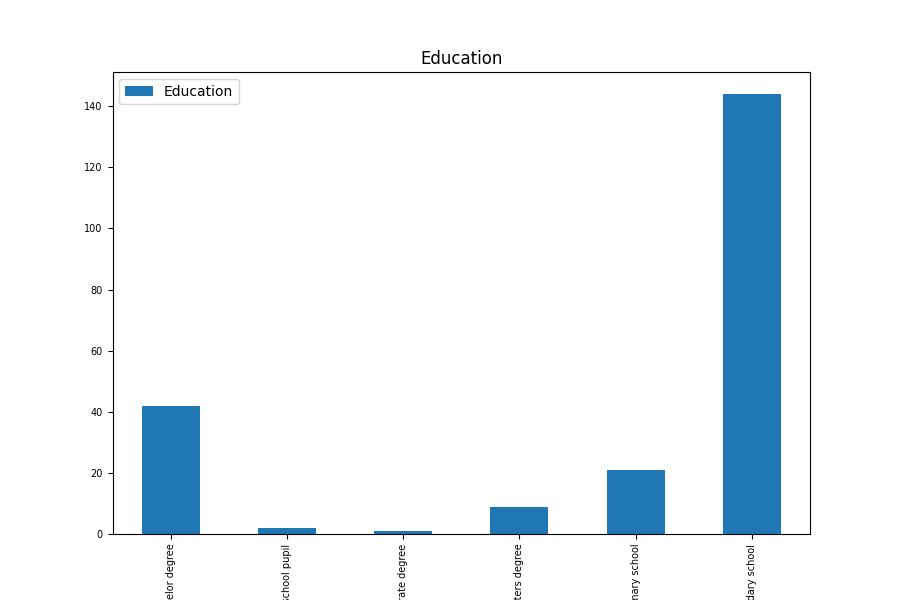

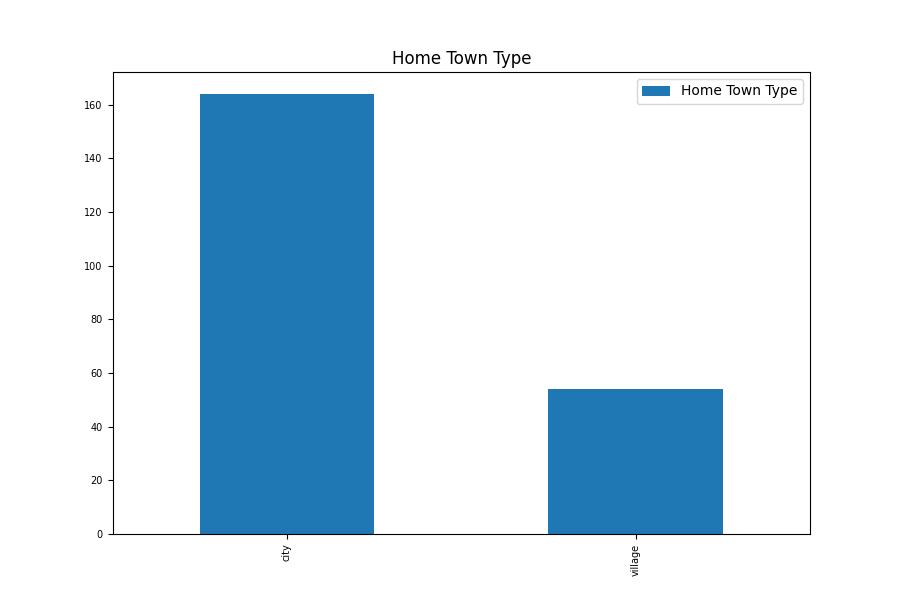

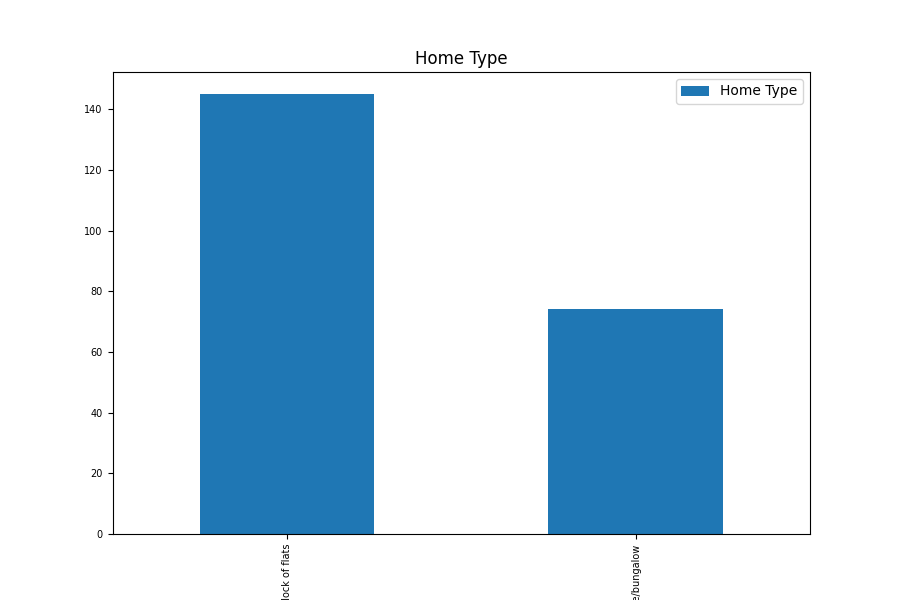

In [47]:
df_cluster = []
df_cluster.append(df_demographics_tot[df_demographics_tot['Cluster label'] == 0])
df_cluster.append(df_demographics_tot[df_demographics_tot['Cluster label'] == 1])
df_cluster.append(df_demographics_tot[df_demographics_tot['Cluster label'] == 2])
print('Cluster: 0')
for col in list(df_cluster[0].columns)[:6]:
    df_cluster[0].loc[:, [col]].apply(pd.value_counts).sort_index().plot(kind = 'bar',fontsize = 7, figsize = (9, 6), title = col)
print('Cluster: 1')
for col in list(df_cluster[1].columns)[:6]:
    df_cluster[1].loc[:, [col]].apply(pd.value_counts).sort_index().plot(kind = 'bar',fontsize = 7, figsize = (9, 6), title = col)
print('Cluster: 2')
for col in list(df_cluster[2].columns)[:6]:
    df_cluster[2].loc[:, [col]].apply(pd.value_counts).sort_index().plot(kind = 'bar',fontsize = 7, figsize = (9, 6), title = col)